# **Building Data Pipeline**

### **Downloading Historical Oil Prices**

Downloading daily Oil prices for both Brent Oil and WTI Oil in USD from EIA through API

In [1]:
import requests
import json
import pandas as pd
import time
from google.colab import userdata

# EIA API Endpoint
EIA_API_URL = "https://api.eia.gov/v2/petroleum/pri/spt/data/"

# API Key
API_KEY = userdata.get('EIAAPI')

# Parameters for data fetching
params_template = {
    "frequency": "daily",
    "data": ["value"],
    "facets": {"product": ["EPCBRENT", "EPCWTI"]},
    "start": "1986-01-03",
    "end": "2024-12-31",
    "sort": [{"column": "period", "direction": "asc"}],
    "length": 5000  # API limit per request
}

offset = 0
all_records = []

while True:
    params = params_template.copy()
    params["offset"] = offset

    headers = {
        "Accept": "application/json",
        "X-Params": json.dumps(params)
    }

    response = requests.get(EIA_API_URL, headers=headers, params={"api_key": API_KEY})

    if response.status_code == 200:
        data = response.json()
        records = data.get("response", {}).get("data", [])

        if not records:
            print("No more data available.")
            break

        all_records.extend(records)
        offset += 5000  # Increment offset to fetch next batch
        print(f"Fetched {len(records)} records, total: {len(all_records)}")
        time.sleep(1)  # To prevent hitting rate limits
    else:
        print(f"Error fetching data: {response.status_code}, {response.text}")
        break

# Convert to DataFrame and Save to CSV
if all_records:
    df_oil_prices_historical = pd.DataFrame(all_records)
    df_oil_prices_historical.to_csv("eia_spot_oil_prices.csv", index=False)
    print("Data successfully saved to eia_spot_oil_prices.csv")
else:
    print("No data fetched.")


Fetched 5000 records, total: 5000
Fetched 5000 records, total: 10000
Fetched 5000 records, total: 15000
Fetched 4371 records, total: 19371
No more data available.
Data successfully saved to eia_spot_oil_prices.csv


In [2]:
print(df_oil_prices_historical)

           period duoarea area-name   product        product-name process  \
0      1986-01-03   YCUOK        NA    EPCWTI       WTI Crude Oil     PF4   
1      1986-01-06   YCUOK        NA    EPCWTI       WTI Crude Oil     PF4   
2      1986-01-07   YCUOK        NA    EPCWTI       WTI Crude Oil     PF4   
3      1986-01-08   YCUOK        NA    EPCWTI       WTI Crude Oil     PF4   
4      1986-01-09   YCUOK        NA    EPCWTI       WTI Crude Oil     PF4   
...           ...     ...       ...       ...                 ...     ...   
19366  2024-12-27     ZEU        NA  EPCBRENT  UK Brent Crude Oil     PF4   
19367  2024-12-30     ZEU        NA  EPCBRENT  UK Brent Crude Oil     PF4   
19368  2024-12-30   YCUOK        NA    EPCWTI       WTI Crude Oil     PF4   
19369  2024-12-31   YCUOK        NA    EPCWTI       WTI Crude Oil     PF4   
19370  2024-12-31     ZEU        NA  EPCBRENT  UK Brent Crude Oil     PF4   

         process-name series  \
0      Spot Price FOB   RWTC   
1      Spot

### **Norway Historical Oil Production**

Data Source: Norway Petroleum

In [3]:
import requests
from bs4 import BeautifulSoup

# URL of the historical production page
url = "https://www.norskpetroleum.no/en/facts/historical-production/"

# Fetch the webpage content
response = requests.get(url)
if response.status_code != 200:
    print(f"Failed to access the page. Status Code: {response.status_code}")
    exit()

# Parse the webpage
soup = BeautifulSoup(response.text, "html.parser")

# Find the CSV download link
csv_link = soup.find("a", class_="action-chart-download")
if csv_link:
    csv_url = "https://www.norskpetroleum.no" + csv_link["href"]  # Full URL
    print(f"CSV Download Link: {csv_url}")

    # Download the CSV file
    csv_response = requests.get(csv_url)
    csv_filename = "Norsk_oil_gas_Historical_Production.csv"

    with open(csv_filename, "wb") as file:
        file.write(csv_response.content)

    print(f"Download complete: {csv_filename}")
else:
    print("CSV download link not found.")


CSV Download Link: https://www.norskpetroleum.no/generator/csv.php?lang=en&from=query&dataSource=production&title=Annual+production&groupBy=year&orderBy=1&orderByAscending=1
Download complete: Norsk_oil_gas_Historical_Production.csv


Data Source: EconDB

In [4]:
import pandas as pd

# Load the dataset
file_path = 'https://www.econdb.com/api/series/JODI_OIL.LD6EDLD6FCLD781.M.NO/?format=csv&token=bfde319e6fedac249fa79d2f4c6696bb873ebdda'
df_production = pd.read_csv(file_path, parse_dates=['Date'])

# Ensure the Date column is in datetime format
df_production ['Date'] = pd.to_datetime(df_production ['Date'], dayfirst=True, errors='coerce')

# Drop any rows where date conversion failed
df_production = df_production.dropna(subset=['Date'])

# Convert daily production to monthly
df_monthly_production_econbd = df_production.resample('ME', on='Date').mean()  # Use .sum() for total production

# Rename the column
df_monthly_production_econbd.rename(columns={df_production.columns[1]: 'Monthly production data in thousand barrel per day'}, inplace=True)

# Save to CSV
output_file = "norway_monthly_oil_production.csv"
df_monthly_production_econbd.to_csv(output_file)

# Display first few rows of the transformed data
df_monthly_production_econbd.head()


Monthly production data in thousand barrel per day
Date                                                          
2002-01-31                                             3226.0 
2002-02-28                                             3282.0 
2002-03-31                                             2893.0 
2002-04-30                                             3284.0 
2002-05-31                                             3180.0

Data Source: EIA

In [5]:
import requests
import pandas as pd
from google.colab import userdata


# Fetch the API key from userdata
API_KEY = userdata.get('EIAAPI')

# Check if the API_KEY is available
if API_KEY is None:
    raise ValueError("API key not found. Please set the EIAAPI key.")

# Define the EIA API v2 URL
SERIES_ID = 'INTL.53-1-NOR-TBPD.M'  # Petroleum production, Norway, Monthly
url = f'https://api.eia.gov/v2/seriesid/{SERIES_ID}?api_key={API_KEY}'

# Fetch the data
response = requests.get(url)
data = response.json()

# Check if the response contains the expected data
if 'response' in data and 'data' in data['response']:
    series_data = data['response']['data']

    # Extract relevant fields: 'period' for date and 'value' for production
    df_monthly_production_eia = pd.DataFrame(series_data, columns=['period', 'value'])

    # Convert 'period' to datetime (format 'YYYY-MM')
    df_monthly_production_eia['Date'] = pd.to_datetime(df_monthly_production_eia['period'], format='%Y-%m')

    # Rename 'value' to 'Production_TBPD' for clarity
    df_monthly_production_eia['Production_TBPD'] = df_monthly_production_eia['value']

    # Drop the 'period' and 'value' columns as they are now in 'Date' and 'Production_TBPD'
    df_monthly_production_eia = df_monthly_production_eia.drop(columns=['period', 'value'])

    # Sort the data by Date
    df_monthly_production_eia = df_monthly_production_eia.sort_values(by='Date')

    # Display the first few rows
    print(df_monthly_production_eia.head(500))
else:
    print("Error fetching data:", data)

          Date  Production_TBPD
383 1993-01-01      2089.000000
382 1993-02-01      2229.000000
381 1993-03-01      2435.000000
380 1993-04-01      2447.000000
379 1993-05-01      2367.000000
..         ...              ...
4   2024-08-01      2006.155770
3   2024-09-01      1741.154538
2   2024-10-01      2006.622124
1   2024-11-01      1977.913125
0   2024-12-01      2032.539621

[384 rows x 2 columns]


Data Source: OurWorldInData. Production Data for all Countries.

In [6]:
import pandas as pd
import requests

# Step 1: Load the dataset
url = "https://ourworldindata.org/grapher/oil-production-by-country.csv?v=1&csvType=full&useColumnShortNames=true"
df = pd.read_csv(url, storage_options={'User-Agent': 'Our World In Data data fetch/1.0'})

# Step 2: Load the metadata
meta_url = "https://ourworldindata.org/grapher/oil-production-by-country.metadata.json?v=1&csvType=full&useColumnShortNames=true"
metadata = requests.get(meta_url).json()

# Step 3: Extract variable/indicator names from metadata
variables = list(metadata['columns'].keys())

# Step 4: Filter only required columns
columns_to_keep = ['Entity', 'Year'] + variables
df = df[columns_to_keep]

# Step 5: Drop rows where all data columns are missing
df = df.dropna(subset=variables, how='all')

# Step 6: Melt to long format
df_long = df.melt(id_vars=['Entity', 'Year'], value_vars=variables,
                  var_name='Indicator', value_name='Value')

# Step 7: Drop missing values
df_long = df_long.dropna(subset=['Value'])

# Step 8: Filter for year range 2000 to max available year
max_year = df_long['Year'].max()
df_countries_production = df_long[(df_long['Year'] >= 2000) & (df_long['Year'] <= max_year)]

# Step 9: Save to CSV with dynamic file name
filename = f"oil_production_by_country_2000_{max_year}.csv"
df_countries_production.to_csv(filename, index=False)

# Output sample
print(f"✅ Data saved to: {filename}")
print(df_countries_production.head())

✅ Data saved to: oil_production_by_country_2000_2023.csv
         Entity  Year            Indicator  Value
20  Afghanistan  2000  oil_production__twh    0.0
21  Afghanistan  2001  oil_production__twh    0.0
22  Afghanistan  2002  oil_production__twh    0.0
23  Afghanistan  2003  oil_production__twh    0.0
24  Afghanistan  2004  oil_production__twh    0.0


### **Download Historical Crude Oil Import/Export Data**

Data Source: EIA

In [7]:
import requests
import json
import pandas as pd
import time
from google.colab import userdata

# EIA API Endpoint
EIA_API_URL = "https://api.eia.gov/v2/crude-oil-imports/data/"

# API Key
API_KEY = userdata.get('EIAAPI')

# Parameters for data fetching
params_template = {
    "frequency": "monthly",
    "data": ["quantity"],
    "facets": {},
    "start": "2009-01",
    "end": "2024-12",
    "sort": [{"column": "period", "direction": "desc"}],
    "length": 5000 # API limit per request
}

offset = 0
all_records = []

while True:
    params = params_template.copy()
    params["offset"] = offset

    headers = {
        "Accept": "application/json",
        "X-Params": json.dumps(params)
    }

    response = requests.get(EIA_API_URL, headers=headers, params={"api_key": API_KEY})

    if response.status_code == 200:
        data = response.json()
        records = data.get("response", {}).get("data", [])

        if not records:
            print("No more data available.")
            break

        all_records.extend(records)
        offset += 5000
        print(f"Fetched {len(records)} records, total: {len(all_records)}")
        time.sleep(1)  # To prevent hitting rate limits
    else:
        print(f"Error fetching data: {response.status_code}, {response.text}")
        break

# Convert to DataFrame and Save to CSV
if all_records:
    df_countries_importexport = pd.DataFrame(all_records)
    df_countries_importexport.to_csv("eia_crude_oil_imports.csv", index=False)
    print("Data successfully saved to eia_crude_oil_imports.csv")
else:
    print("No data fetched.")

Fetched 5000 records, total: 5000
Fetched 5000 records, total: 10000
Fetched 5000 records, total: 15000
Fetched 5000 records, total: 20000
Fetched 5000 records, total: 25000
Fetched 5000 records, total: 30000
Fetched 5000 records, total: 35000
Fetched 5000 records, total: 40000
Fetched 5000 records, total: 45000
Fetched 5000 records, total: 50000
Fetched 5000 records, total: 55000
Fetched 5000 records, total: 60000
Fetched 5000 records, total: 65000
Fetched 5000 records, total: 70000
Fetched 5000 records, total: 75000
Fetched 5000 records, total: 80000
Fetched 5000 records, total: 85000
Fetched 5000 records, total: 90000
Fetched 5000 records, total: 95000
Fetched 5000 records, total: 100000
Fetched 5000 records, total: 105000
Fetched 5000 records, total: 110000
Fetched 5000 records, total: 115000
Fetched 5000 records, total: 120000
Fetched 5000 records, total: 125000
Fetched 5000 records, total: 130000
Fetched 5000 records, total: 135000
Fetched 5000 records, total: 140000
Fetched 5000

Only Norway Export Data. Data Source: EIA

In [8]:
import requests
import pandas as pd
from google.colab import userdata

# Fetch the API key from userdata
API_KEY = userdata.get('EIAAPI')

# Check if the API_KEY is available
if API_KEY is None:
    raise ValueError("API key not found. Please set the EIAAPI key.")

# Define the EIA API v2 URL for Crude oil exports data
SERIES_ID = 'INTL.57-4-NOR-TBPD.A'  # Crude oil exports, Norway, Annual
url = f'https://api.eia.gov/v2/seriesid/{SERIES_ID}?api_key={API_KEY}'

# Fetch the data
response = requests.get(url)
data = response.json()

# Check if the response contains the expected data
if 'response' in data and 'data' in data['response']:
    series_data = data['response']['data']

    # Extract relevant fields: 'period' for year and 'value' for crude oil exports
    exports_data = pd.DataFrame(series_data, columns=['period', 'value'])

    # Convert 'period' to datetime format (keeping only the year)
    exports_data['Year'] = pd.to_datetime(exports_data['period'], format='%Y').dt.year

    # Rename 'value' to 'Crude_Oil_Exports_TBPD' for clarity
    exports_data['Crude_Oil_Exports_TBPD'] = exports_data['value']

    # Drop the original 'period' and 'value' columns
    exports_data = exports_data.drop(columns=['period', 'value'])

    # Sort the data by Year
    df_exports_data = exports_data.sort_values(by='Year')

    # Export the data to CSV file
    file_name = 'Norway_Crude_Oil_Exports.csv'
    df_exports_data.to_csv(file_name, index=False)
    print(f"Data successfully exported to {file_name}")
else:
    print("Error fetching data:", data)


Data successfully exported to Norway_Crude_Oil_Exports.csv


### **Yearly Oil Rent Data**

Data is manually downloaded from World Bank and Uploaded

In [9]:
import pandas as pd

try:
  df_oil_rent = pd.read_excel('Oil Rent_15385.xls', sheet_name='Data', skiprows=3)
  print(df_oil_rent.head()) # Check if the import and skipping is working as expected

except FileNotFoundError:
  print("Error: 'Oil Rent_15385.xlsx' not found in the current directory.")
except Exception as e:
  print(f"An error occurred: {e}")


                  Country Name Country Code        Indicator Name  \
0                        Aruba          ABW  Oil rents (% of GDP)   
1  Africa Eastern and Southern          AFE  Oil rents (% of GDP)   
2                  Afghanistan          AFG  Oil rents (% of GDP)   
3   Africa Western and Central          AFW  Oil rents (% of GDP)   
4                       Angola          AGO  Oil rents (% of GDP)   

      Indicator Code  1960  1961  1962  1963  1964  1965  ...       2014  \
0  NY.GDP.PETR.RT.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   0.000000   
1  NY.GDP.PETR.RT.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   3.858704   
2  NY.GDP.PETR.RT.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   0.040744   
3  NY.GDP.PETR.RT.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   6.642740   
4  NY.GDP.PETR.RT.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...  21.736607   

        2015       2016       2017       2018       2019       2020  \
0   0.000000   0.000000   0.000000   0.000000   0.000000 

### **Oil Reserve**

Data Source: World Data Bank. Manually downloaded

In [10]:
import pandas as pd

try:
  df_norway_oil_reserve = pd.read_excel('Oil Reserves.xlsx', sheet_name='Oil Reserves', skiprows=3)
  print(df.head()) # Check if the import and skipping is working as expected

except FileNotFoundError:
  print("Error: 'Oil Reserves.xlsx' not found in the current directory.")
except Exception as e:
  print(f"An error occurred: {e}")

        Entity  Year  oil_production__twh
0  Afghanistan  1980                  0.0
1  Afghanistan  1981                  0.0
2  Afghanistan  1982                  0.0
3  Afghanistan  1983                  0.0
4  Afghanistan  1984                  0.0


Data Source: WorldInData

In [11]:
import pandas as pd
import requests

# Step 1: Load the dataset
data_url = "https://ourworldindata.org/grapher/oil-proved-reserves.csv?v=1&csvType=full&useColumnShortNames=true"
df = pd.read_csv(data_url, storage_options={'User-Agent': 'Our World In Data data fetch/1.0'})

# Step 2: Load the metadata
meta_url = "https://ourworldindata.org/grapher/oil-proved-reserves.metadata.json?v=1&csvType=full&useColumnShortNames=true"
metadata = requests.get(meta_url).json()

# Step 3: Extract the main variable name from metadata
oil_variable = list(metadata['columns'].keys())[0]  # Usually "Oil proved reserves (Barrels)"

# Step 4: Filter relevant columns and drop missing values
df_clean = df[['Entity', 'Year', oil_variable]].dropna()

# Step 5: Rename columns
df_clean.columns = ['Country', 'Year', 'Oil_reserves_tonnes']

# Step 6: Convert to numeric if needed
df_clean['Oil_reserves_tonnes'] = pd.to_numeric(df_clean['Oil_reserves_tonnes'], errors='coerce')

# Step 7: Filter for years 2000 to 2024
df_countries_oilreserve = df_clean[(df_clean['Year'] >= 2000) & (df_clean['Year'] <= 2024)]

# Step 8: Save to CSV
max_year = df_countries_oilreserve['Year'].max()
df_countries_oilreserve.to_csv(f'oil_proved_reserves_2000_{max_year}.csv', index=False)

# Show a sample

### **Yearly GDP Data in USD from EIA**

Data Source: EIA

In [12]:
import requests
import pandas as pd
from google.colab import userdata

# Fetch the API key from userdata
API_KEY = userdata.get('EIAAPI')

# Check if the API_KEY is available
if API_KEY is None:
    raise ValueError("API key not found. Please set the EIAAPI key.")

# Define the EIA API v2 URL
SERIES_ID = 'INTL.4701-34-NOR-BDOLPPP.A'  # GDP at PPP, Norway, Annual
url = f'https://api.eia.gov/v2/seriesid/{SERIES_ID}?api_key={API_KEY}'

# Fetch the data
response = requests.get(url)
data = response.json()

# Check if the response contains the expected data
if 'response' in data and 'data' in data['response']:
    series_data = data['response']['data']

    # Extract relevant fields: 'period' for year and 'value' for GDP
    GDP_Data = pd.DataFrame(series_data, columns=['period', 'value'])

    # Convert 'period' to datetime format (keeping only the year)
    GDP_Data['Year'] = pd.to_datetime(GDP_Data['period'], format='%Y').dt.year

    # Rename 'value' to 'GDP_BDOLPPP' for clarity
    GDP_Data['GDP_BDOLPPP'] = GDP_Data['value']

    # Drop the original 'period' and 'value' columns
    GDP_Data = GDP_Data.drop(columns=['period', 'value'])

    # Sort the data by Year
    GDP_Data = GDP_Data.sort_values(by='Year')

    # Calculate GDP Growth (year-over-year) and convert it to percentage
    GDP_Data['GDP_Growth_Actual'] = GDP_Data['GDP_BDOLPPP'].pct_change() * 100

    # Format the percentage column to 2 decimal places
    GDP_Data['GDP_Growth_Actual'] = GDP_Data['GDP_Growth_Actual'].map(lambda x: f"{x:.2f}%" if pd.notnull(x) else "N/A")

    # Display the first few rows
    print(GDP_Data.head(45))
else:
    print("Error fetching data:", data)

    Year  GDP_BDOLPPP GDP_Growth_Actual
44  1980     135.4461               N/A
43  1981     137.6109             1.60%
42  1982     137.9349             0.24%
41  1983     143.4151             3.97%
40  1984     152.0951             6.05%
39  1985     160.5415             5.55%
38  1986     167.0307             4.04%
37  1987     169.9597             1.75%
36  1988     169.5260            -0.26%
35  1989     171.2861             1.04%
34  1990     174.5960             1.93%
33  1991     179.9812             3.08%
32  1992     186.4146             3.57%
31  1993     191.7184             2.85%
30  1994     201.4104             5.06%
29  1995     209.7802             4.16%
28  1996     220.3278             5.03%
27  1997     231.9712             5.28%
26  1998     238.1619             2.67%
25  1999     243.0967             2.07%
24  2000     251.1649             3.32%
23  2001     256.3568             2.07%
22  2002     259.8883             1.38%
21  2003     262.3440             0.94%


### **Interest Rates**

In [13]:
import requests

# Direct CSV URL
csv_url = "https://data.norges-bank.no/api/data/IR/M.KPRA.OL+RR+SD.R?format=csv&lastNObservations=60&locale=en"

# Send request to download CSV
response = requests.get(csv_url)

# Save file if request is successful
if response.status_code == 200:
    filename = "norges_bank_data.csv"
    with open(filename, "wb") as file:
        file.write(response.content)
    print(f"File saved as {filename}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")


import pandas as pd

# Read the CSV with semicolon separator
df_interest_rate = pd.read_csv("norges_bank_data.csv", sep=";")

# Display first few rows
print(df_interest_rate.head())

File saved as norges_bank_data.csv
  FREQ Frequency INSTRUMENT_TYPE  Instrument Type TENOR  \
0    M   Monthly            KPRA  Key policy rate    OL   
1    M   Monthly            KPRA  Key policy rate    OL   
2    M   Monthly            KPRA  Key policy rate    OL   
3    M   Monthly            KPRA  Key policy rate    OL   
4    M   Monthly            KPRA  Key policy rate    OL   

                    Tenor UNIT_MEASURE Unit of Measure  DECIMALS COLLECTION  \
0  Overnight lending rate            R            Rate         2          A   
1  Overnight lending rate            R            Rate         2          A   
2  Overnight lending rate            R            Rate         2          A   
3  Overnight lending rate            R            Rate         2          A   
4  Overnight lending rate            R            Rate         2          A   

                         Collection Indicator TIME_PERIOD  OBS_VALUE  \
0  Average of observations through period (A)     2020-04      

### **Oslo Index Return**

In [14]:
import yfinance as yf

# Define the correct ticker symbol
ticker_symbol = "OBX.OL"

# Set the time frame
start_date = "1985-04-03"
end_date = "2025-04-03"

# Fetch the data
df_oslo_return = yf.download(ticker_symbol, start=start_date, end=end_date)

# Save to CSV with semicolon separator
df_oslo_return.to_csv("OSEBX_GR_Historical_Data.csv", sep=';')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


### **Exchange Rate**

In [15]:
import yfinance as yf

# Fetch historical NOK/USD exchange rates
nok_usd = yf.download("NOKUSD=X", start="2000-01-01", end="2025-04-01", interval="1d")

# Save to CSV
nok_usd.to_csv("NOKUSD_exchange_rates.csv")

# Display the first few rows
print(nok_usd.head())

[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open   Volume
Ticker      NOKUSD=X  NOKUSD=X  NOKUSD=X  NOKUSD=X NOKUSD=X
Date                                                       
2001-07-16  0.106793  0.107774  0.106759  0.107611        0
2001-07-17  0.107364  0.107640  0.106443  0.106652        0
2001-07-18  0.109187  0.109217  0.106903  0.107290        0
2001-07-19  0.108924  0.109570  0.108479  0.108995        0
2001-07-20  0.108767  0.109649  0.108462  0.109384        0


### **Inflation Rate**

Data Source: World Bank

In [16]:
import pandas as pd

try:
  df_inflation_rate = pd.read_excel('Inflation_26405.xls', sheet_name='Data', skiprows=3)
  print(df_inflation_rate.head()) # Check if the import and skipping is working as expected

except FileNotFoundError:
  print("Error: 'Inflation_26405.xlsx' not found in the current directory.")
except Exception as e:
  print(f"An error occurred: {e}")

                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                          Indicator Name  Indicator Code  1960  1961  1962  \
0  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG   NaN   NaN   NaN   
1  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG   NaN   NaN   NaN   
2  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG   NaN   NaN   NaN   
3  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG   NaN   NaN   NaN   
4  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG   NaN   NaN   NaN   

   1963  1964  1965  ...      2014      2015       2016       2017       2018  \
0   NaN   NaN   NaN  ...  0.421441  0.474764  -0.931196  -1.028282   3.626041   
1   NaN   NaN   NaN  ...  5.370290  5.245878   6.571396   6.399343   4.720805   
2   N

Data Source: OurWorldInData

In [17]:
import pandas as pd
import requests

# Step 1: Fetch the data
data_url = "https://ourworldindata.org/grapher/inflation-of-consumer-prices.csv?v=1&csvType=full&useColumnShortNames=true"
df = pd.read_csv(data_url, storage_options={'User-Agent': 'Our World In Data data fetch/1.0'})

# Step 2: Fetch metadata
meta_url = "https://ourworldindata.org/grapher/inflation-of-consumer-prices.metadata.json?v=1&csvType=full&useColumnShortNames=true"
metadata = requests.get(meta_url).json()

# Step 3: Extract indicator/variable names from metadata
variables = list(metadata['columns'].keys())

# Step 4: Keep only relevant columns
columns_to_keep = ['Entity', 'Year'] + variables
df = df[columns_to_keep]

# Step 5: Drop rows where all data columns are missing
df = df.dropna(subset=variables, how='all')

# Step 6: Reshape to long format
df_long = df.melt(id_vars=['Entity', 'Year'], value_vars=variables,
                  var_name='Indicator', value_name='Value')

# Step 7: Drop missing values
df_long = df_long.dropna(subset=['Value'])

# Step 8: Filter years from 2000 to max year
max_year = df_long['Year'].max()
df_countries_inflation = df_long[(df_long['Year'] >= 2000) & (df_long['Year'] <= max_year)]

# Step 9: Save to CSV with dynamic file name
filename = f"inflation_consumer_prices_2000_{max_year}.csv"
df_countries_inflation.to_csv(filename, index=False)

# Step 10: Print confirmation and preview
print(f"✅ Data saved to: {filename}")
print(df_countries_inflation.head())


✅ Data saved to: inflation_consumer_prices_2000_2023.csv
        Entity  Year       Indicator      Value
0  Afghanistan  2005  fp_cpi_totl_zg  12.686269
1  Afghanistan  2006  fp_cpi_totl_zg   6.784596
2  Afghanistan  2007  fp_cpi_totl_zg   8.680571
3  Afghanistan  2008  fp_cpi_totl_zg  26.418665
4  Afghanistan  2009  fp_cpi_totl_zg  -6.811161


# **Short Term Oil Production**

With a focus on near-term dynamics, we’ll prioritize recent and high-frequency variables such as prices, exports, interest rate trends, and financial market signals. Hence, We will be using the below datasets for forecasting the short term oil production

1. Oil Prices
2. Monthly Oil Production
3. Interest Rate
4. Oslo Market Returns
5. USD/NOK Returns

These datasets should provide a strong foundation for forecasting short-term oil production in Norway.

## **EDA**

1. Converting daily Oil prices to monthly from 2019 to 2024 only for UK Brent Crude Oil which is the baseline for Norway Oil

In [19]:
import pandas as pd

# Ensure 'period' is in datetime format
df_oil_prices_historical['period'] = pd.to_datetime(df_oil_prices_historical['period'], errors='coerce')

# Filter for 2019–2024 and UK Brent Crude Oil
df_filtered = df_oil_prices_historical[
    (df_oil_prices_historical['period'].dt.year >= 2019) &
    (df_oil_prices_historical['period'].dt.year <= 2024) &
    (df_oil_prices_historical['product-name'] == 'UK Brent Crude Oil')
].copy()

# Convert 'value' to numeric safely
df_filtered.loc[:, 'value'] = pd.to_numeric(df_filtered['value'], errors='coerce')

# Drop NaNs
df_filtered = df_filtered.dropna(subset=['value'])

# Group by year-month and average
df_filtered['YearMonth'] = df_filtered['period'].dt.to_period('M')
df_monthly_short_term = df_filtered.groupby('YearMonth')['value'].mean().reset_index()

# Rename columns
df_monthly_short_term.columns = ['Period', 'Monthly Average Value']
df_monthly_short_term['Period'] = df_monthly_short_term['Period'].dt.to_timestamp()

# Final output
df_monthly_short_term.head()

Period Monthly Average Value
0 2019-01-01             59.409545
1 2019-02-01               63.9605
2 2019-03-01             66.138571
3 2019-04-01             71.233333
4 2019-05-01             71.172609

2. Taking the monthly production data and adding it to the short term dataframe

In [20]:
df_monthly_production_eia.head()


Date  Production_TBPD
383 1993-01-01           2089.0
382 1993-02-01           2229.0
381 1993-03-01           2435.0
380 1993-04-01           2447.0
379 1993-05-01           2367.0

In [21]:
# Step 1: Filter data between 2019 and 2024
df_filtered = df_monthly_production_eia[
    (df_monthly_production_eia['Date'] >= '2019-01-01') &
    (df_monthly_production_eia['Date'] <= '2025-1-01')
].copy()

# Step 2: Convert the 'Date' column to the desired format ('YYYY-MM')
df_filtered['Date'] = df_filtered['Date'].dt.strftime('%Y-%m')

# Step 3: Rename 'Date' to 'period'
df_filtered.rename(columns={'Date': 'Period'}, inplace=True)

# Optional: Display the first few rows
print(df_filtered.head(75))


     Period  Production_TBPD
71  2019-01      1826.044632
70  2019-02      1752.354529
69  2019-03      1761.724310
68  2019-04      1725.262600
67  2019-05      1594.734955
..      ...              ...
4   2024-08      2006.155770
3   2024-09      1741.154538
2   2024-10      2006.622124
1   2024-11      1977.913125
0   2024-12      2032.539621

[72 rows x 2 columns]


In [22]:
df_filtered['Period'] = pd.to_datetime(df_filtered['Period'])


# Merge the two dataframes based on the 'Period' column
df_monthly_short_term1= pd.merge(df_filtered, df_monthly_short_term, on='Period', how='left')


print(df_monthly_short_term1.head(73))

       Period  Production_TBPD Monthly Average Value
0  2019-01-01      1826.044632             59.409545
1  2019-02-01      1752.354529               63.9605
2  2019-03-01      1761.724310             66.138571
3  2019-04-01      1725.262600             71.233333
4  2019-05-01      1594.734955             71.172609
..        ...              ...                   ...
67 2024-08-01      2006.155770             80.355238
68 2024-09-01      1741.154538             74.016667
69 2024-10-01      2006.622124             75.632609
70 2024-11-01      1977.913125             74.345238
71 2024-12-01      2032.539621             73.842381

[72 rows x 3 columns]


3. Taking the Interest Rate data and adding it to the short term dataframe

In [23]:
df_interest_rate.head(500)

FREQ Frequency INSTRUMENT_TYPE  Instrument Type TENOR  \
0      M   Monthly            KPRA  Key policy rate    OL   
1      M   Monthly            KPRA  Key policy rate    OL   
2      M   Monthly            KPRA  Key policy rate    OL   
3      M   Monthly            KPRA  Key policy rate    OL   
4      M   Monthly            KPRA  Key policy rate    OL   
..   ...       ...             ...              ...   ...   
175    M   Monthly            KPRA  Key policy rate    SD   
176    M   Monthly            KPRA  Key policy rate    SD   
177    M   Monthly            KPRA  Key policy rate    SD   
178    M   Monthly            KPRA  Key policy rate    SD   
179    M   Monthly            KPRA  Key policy rate    SD   

                      Tenor UNIT_MEASURE Unit of Measure  DECIMALS COLLECTION  \
0    Overnight lending rate            R            Rate         2          A   
1    Overnight lending rate            R            Rate         2          A   
2    Overnight lending rate            R            Rate         2          A   
3    Overnight lending rate            R            Rate         2          A   
4    Overnight lending rate            R            Rate         2          A   
..                      ...          ...             ...       ...        ...   
175             Policy rate            R            Rate         2          A   
176             Policy rate            R            Rate         2          A   
177             Policy rate            R            Rate         2          A   
178             Policy rate            R            Rate         2          A   
179             Policy rate            R            Rate         2          A   

                           Collection Indicator TIME_PERIOD  OBS_VALUE  \
0    Average of observations through period (A)     2020-04       1.25   
1    Average of observations through period (A)     2020-05       1.05   
2    Average of observations through period (A)     2020-06       1.00   
3    Average of observations through period (A)     2020-07       1.00   
4    Average of observations through period (A)     2020-08       1.00   
..                                          ...         ...        ...   
175  Average of observations through period (A)     2024-11       4.50   
176  Average of observations through period (A)     2024-12       4.50   
177  Average of observations through period (A)     2025-01       4.50   
178  Average of observations through period (A)     2025-02       4.50   
179  Average of observations through period (A)     2025-03       4.50   

     CALC_METHOD  Calculation Method  
0            NaN                 NaN  
1            NaN                 NaN  
2            NaN                 NaN  
3            NaN                 NaN  
4            NaN                 NaN  
..           ...                 ...  
175          NaN                 NaN  
176          NaN                 NaN  
177          NaN                 NaN  
178          NaN                 NaN  
179          NaN                 NaN  

[180 rows x 15 columns]

In [24]:
import pandas as pd

# Step 1: Filter data between 2019 and 2024
df_filtered = df_interest_rate[
    df_interest_rate["TIME_PERIOD"].str.startswith(tuple(str(year) for year in range(2019, 2025)))
]

# Step 2: Create a new dataframe
new_df = df_filtered.copy()

# Step 3: Rename TIME_PERIOD to Period and convert to datetime for filtering
new_df = new_df.rename(columns={"TIME_PERIOD": "Period"})
new_df["Period"] = pd.to_datetime(new_df["Period"])
new_df["Period"] = new_df["Period"].dt.to_period("M").astype(str)  # Format to YYYY-MM

# Step 4: Keep relevant columns only
new_df = new_df[["Tenor", "Period", "OBS_VALUE"]]

# Step 5: Separate Tenors
overnight_df = new_df[new_df['Tenor'] == 'Overnight lending rate'].copy()
overnight_df = overnight_df.rename(columns={'OBS_VALUE': 'Overnight Lending Rate'})
overnight_df = overnight_df.drop(columns=['Tenor'])

policy_df = new_df[new_df['Tenor'] == 'Policy rate'].copy()
policy_df = policy_df.rename(columns={'OBS_VALUE': 'Policy Rate'})
policy_df = policy_df.drop(columns=['Tenor'])

# Step 6: Merge both datasets
result_df = pd.merge(overnight_df, policy_df, on="Period", how="outer")

# Step 7: Fill missing periods from 2019-01 to 2020-03
full_periods = pd.date_range(start='2019-01', end='2024-12', freq='MS').to_period("M").astype(str)
result_df = result_df.set_index("Period").reindex(full_periods).reset_index()
result_df = result_df.rename(columns={'index': 'Period'})

# Step 8: Fill missing values in 2019-01 to 2020-03 with average of that range
mask = (result_df["Period"] >= '2019-01') & (result_df["Period"] <= '2020-03')

# Compute average for each column where values exist in that range
avg_overnight = result_df.loc[mask, "Overnight Lending Rate"].mean(skipna=True)
avg_policy = result_df.loc[mask, "Policy Rate"].mean(skipna=True)

# Fill NaNs only in 2019-01 to 2020-03 with computed averages
result_df.loc[mask & result_df["Overnight Lending Rate"].isna(), "Overnight Lending Rate"] = avg_overnight
result_df.loc[mask & result_df["Policy Rate"].isna(), "Policy Rate"] = avg_policy

# Final clean dataframe
result_df = result_df.sort_values("Period").reset_index(drop=True)

# Display result
print(result_df.head(72))


     Period  Overnight Lending Rate  Policy Rate
0   2019-01                     NaN          NaN
1   2019-02                     NaN          NaN
2   2019-03                     NaN          NaN
3   2019-04                     NaN          NaN
4   2019-05                     NaN          NaN
..      ...                     ...          ...
67  2024-08                     5.5          4.5
68  2024-09                     5.5          4.5
69  2024-10                     5.5          4.5
70  2024-11                     5.5          4.5
71  2024-12                     5.5          4.5

[72 rows x 3 columns]


In [25]:
result_df['Period'] = pd.to_datetime(result_df['Period'])

# Merge the two dataframes based on the 'Period' column
df_monthly_short_term2 = pd.merge(result_df, df_monthly_short_term1, on='Period', how='left')


print(df_monthly_short_term2.head(73))

       Period  Overnight Lending Rate  Policy Rate  Production_TBPD  \
0  2019-01-01                     NaN          NaN      1826.044632   
1  2019-02-01                     NaN          NaN      1752.354529   
2  2019-03-01                     NaN          NaN      1761.724310   
3  2019-04-01                     NaN          NaN      1725.262600   
4  2019-05-01                     NaN          NaN      1594.734955   
..        ...                     ...          ...              ...   
67 2024-08-01                     5.5          4.5      2006.155770   
68 2024-09-01                     5.5          4.5      1741.154538   
69 2024-10-01                     5.5          4.5      2006.622124   
70 2024-11-01                     5.5          4.5      1977.913125   
71 2024-12-01                     5.5          4.5      2032.539621   

   Monthly Average Value  
0              59.409545  
1                63.9605  
2              66.138571  
3              71.233333  
4           

4. Converting daily Market data into yearly returns from 2019 to 2024

In [26]:
df_oslo_return.head()

Price            Close        High         Low        Open Volume
Ticker          OBX.OL      OBX.OL      OBX.OL      OBX.OL OBX.OL
Date                                                             
2004-09-27  184.210007  184.210007  183.600006  183.720001      0
2004-09-28  184.869995  185.470001  184.169998  184.199997      0
2004-09-29  185.050003  186.580002  184.710007  185.080002      0
2004-09-30  185.279999  185.940002  184.770004  185.050003      0
2004-10-01  188.830002  188.830002  185.380005  185.380005      0

In [27]:
import pandas as pd

# Step 1: Copy original dataframe
df_filtered = df_oslo_return.copy()

# Step 2: Ensure index is datetime
df_filtered.index = pd.to_datetime(df_filtered.index)

# Step 3: Filter data between 2019 and 2024
df_filtered = df_filtered[(df_filtered.index >= '2018-12-01') & (df_filtered.index <= '2024-12-31')]

# Step 4: Resample to month-end and get last closing price of each month
monthly_close = df_filtered['Close'].resample('M').last()

# Step 5: Calculate monthly returns
monthly_returns = monthly_close.pct_change().dropna()

# Step 6: Construct final DataFrame
Oslo_result_df = pd.DataFrame({
    'Period': monthly_returns.index.to_period('M').astype(str),
    'Oslo Monthly Returns': monthly_returns.values.flatten()  # Ensure it's 1D
})

# Show output
print(Oslo_result_df.head(72))




     Period  Oslo Monthly Returns
0   2019-01              0.047957
1   2019-02              0.030934
2   2019-03             -0.006910
3   2019-04              0.023710
4   2019-05             -0.034268
..      ...                   ...
67  2024-08             -0.013338
68  2024-09             -0.017735
69  2024-10              0.010883
70  2024-11              0.017435
71  2024-12             -0.022794

[72 rows x 2 columns]


<ipython-input-27-e62a5c35d40a>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_close = df_filtered['Close'].resample('M').last()


In [28]:
Oslo_result_df['Period'] = pd.to_datetime(result_df['Period'])

# Merge the two dataframes based on the 'Period' column
df_monthly_short_term3 = pd.merge(Oslo_result_df, df_monthly_short_term2, on='Period', how='left')


print(df_monthly_short_term3.head(73))

       Period  Oslo Monthly Returns  Overnight Lending Rate  Policy Rate  \
0  2019-01-01              0.047957                     NaN          NaN   
1  2019-02-01              0.030934                     NaN          NaN   
2  2019-03-01             -0.006910                     NaN          NaN   
3  2019-04-01              0.023710                     NaN          NaN   
4  2019-05-01             -0.034268                     NaN          NaN   
..        ...                   ...                     ...          ...   
67 2024-08-01             -0.013338                     5.5          4.5   
68 2024-09-01             -0.017735                     5.5          4.5   
69 2024-10-01              0.010883                     5.5          4.5   
70 2024-11-01              0.017435                     5.5          4.5   
71 2024-12-01             -0.022794                     5.5          4.5   

    Production_TBPD Monthly Average Value  
0       1826.044632             59.409545  

5. Taking the FX return data and adding it to the short term dataframe

In [29]:
import pandas as pd

# Step 1: Copy original dataframe
df_filtered = nok_usd.copy()

# Step 2: Ensure index is datetime
df_filtered.index = pd.to_datetime(df_filtered.index)

# Step 3: Filter data between 2019 and 2024
df_filtered = df_filtered[(df_filtered.index >= '2018-12-01') & (df_filtered.index <= '2024-12-31')]

# Step 4: Resample to month-end and get last closing price of each month
monthly_close = df_filtered['Close'].resample('M').last()

# Step 5: Calculate monthly returns
monthly_returns = monthly_close.pct_change().dropna()

# Step 6: Construct final DataFrame
fx_result_df = pd.DataFrame({
    'Period': monthly_returns.index.to_period('M').astype(str),
    'Monthly FX Returns': monthly_returns.values.flatten()  # Ensure it's 1D
})

# Show output
print(fx_result_df.head(72))


     Period  Monthly FX Returns
0   2019-01            0.034452
1   2019-02           -0.014679
2   2019-03           -0.010528
3   2019-04           -0.002218
4   2019-05           -0.013966
..      ...                 ...
67  2024-08            0.042415
68  2024-09            0.001486
69  2024-10           -0.043481
70  2024-11           -0.006922
71  2024-12           -0.025603

[72 rows x 2 columns]


<ipython-input-29-d02932c9287c>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_close = df_filtered['Close'].resample('M').last()


In [30]:
fx_result_df['Period'] = pd.to_datetime(result_df['Period'])

# Merge the two dataframes based on the 'Period' column
df_monthly_short_term_final = pd.merge(fx_result_df, df_monthly_short_term3, on='Period', how='left')


print(df_monthly_short_term_final.head(73))

       Period  Monthly FX Returns  Oslo Monthly Returns  \
0  2019-01-01            0.034452              0.047957   
1  2019-02-01           -0.014679              0.030934   
2  2019-03-01           -0.010528             -0.006910   
3  2019-04-01           -0.002218              0.023710   
4  2019-05-01           -0.013966             -0.034268   
..        ...                 ...                   ...   
67 2024-08-01            0.042415             -0.013338   
68 2024-09-01            0.001486             -0.017735   
69 2024-10-01           -0.043481              0.010883   
70 2024-11-01           -0.006922              0.017435   
71 2024-12-01           -0.025603             -0.022794   

    Overnight Lending Rate  Policy Rate  Production_TBPD Monthly Average Value  
0                      NaN          NaN      1826.044632             59.409545  
1                      NaN          NaN      1752.354529               63.9605  
2                      NaN          NaN      176

## **Profiling and Modeling**

### **Showing Data Profile using YData**

In [31]:
!pip install ydata_profiling
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 72.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=0e509c2d7239095161b76612bb48bc07e04395fed019ded393497698ca722230
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [32]:
# Generate data profiling report
profile = ProfileReport(df_monthly_short_term_final, explorative=True)
profile.to_file("data_profiling_report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 167.78it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### **SARIMA Implementation**

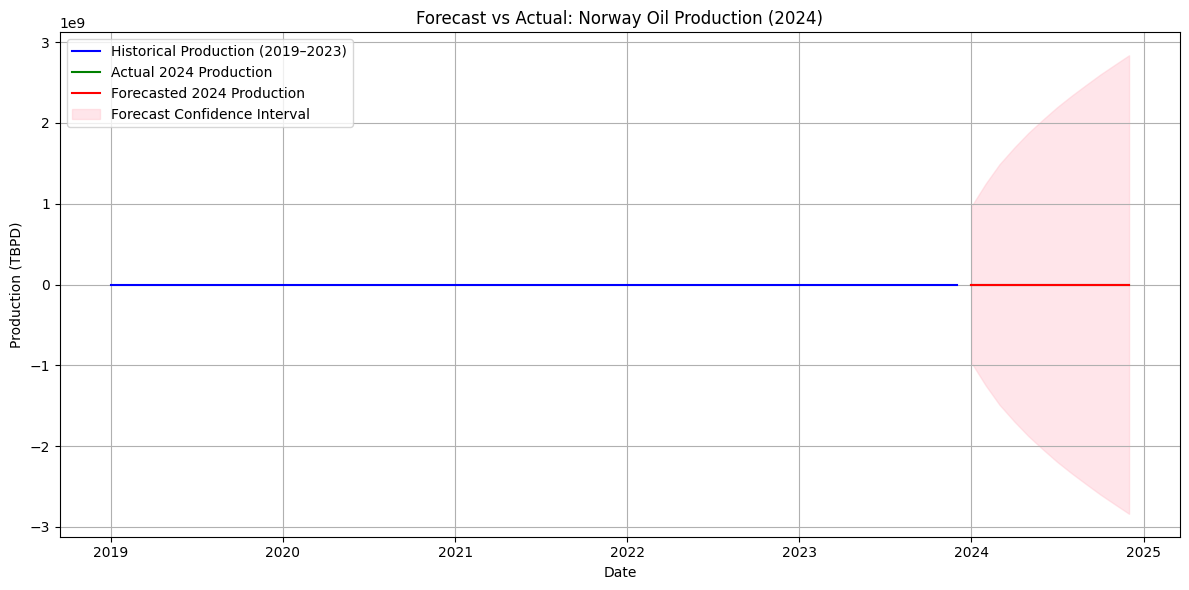


Mean Absolute Error (2024): 109.00 TBPD

Forecast vs Actual Production (2024):
       Period  Forecasted_Production_TBPD SARIMA  Actual_Production_TBPD
0  2024-01-01                        2008.949649             2080.052438
1  2024-02-01                        2039.565091             2009.094119
2  2024-03-01                        1990.465985             2098.327448
3  2024-04-01                        1905.276818             2097.501286
4  2024-05-01                        1859.637849             1960.029720
5  2024-06-01                        1587.331807             1976.620942
6  2024-07-01                        1916.624441             2089.062993
7  2024-08-01                        2050.714696             2006.155770
8  2024-09-01                        1878.808041             1741.154538
9  2024-10-01                        2015.892798             2006.622124
10 2024-11-01                        2019.646779             1977.913125
11 2024-12-01                        2043.50

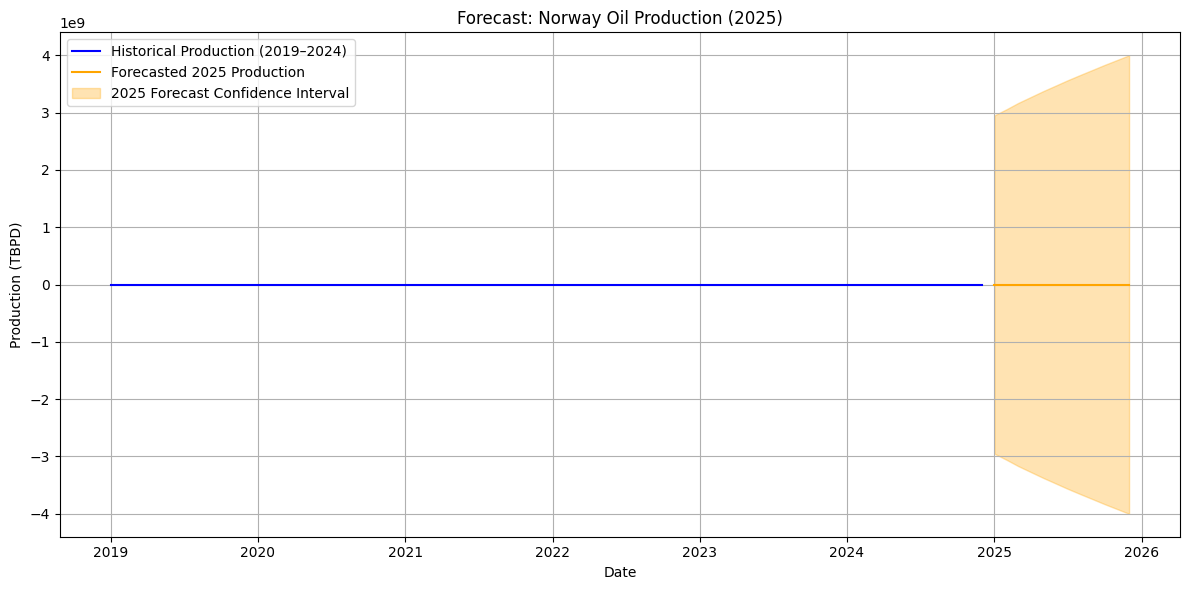


Forecasted Production (2025):
       Period  Forecasted_Production_TBPD SARIMA
0  2025-01-01                        2037.410030
1  2025-02-01                        2045.804322
2  2025-03-01                        2102.020301
3  2025-04-01                        2089.565192
4  2025-05-01                        2045.155663
5  2025-06-01                        2053.525211
6  2025-07-01                        2099.619371
7  2025-08-01                        2055.997304
8  2025-09-01                        1895.748410
9  2025-10-01                        2027.864603
10 2025-11-01                        2085.962453
11 2025-12-01                        2162.119454


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use the correct column name, i.e., 'Period'
df = df_monthly_short_term_final.copy()

# Step 1: Parse and set datetime index (correct column name 'Period')
df['Period'] = pd.to_datetime(df['Period'])
df = df.sort_values('Period')
df.set_index('Period', inplace=True)

# Step 2: Ensure numeric data for the target variable 'Production_TBPD'
df['Production_TBPD'] = pd.to_numeric(df['Production_TBPD'], errors='coerce')
df['Production_TBPD'] = df['Production_TBPD'].ffill()  # Fill missing values

# Step 3: Sanity check to ensure 'Production_TBPD' is numeric
assert np.issubdtype(df['Production_TBPD'].dtype, np.number), "Production_TBPD is not numeric"

# Step 4: Split data into training (2019–2023) and testing (2024)
train = df.loc['2019-01-01':'2023-12-31', 'Production_TBPD']
test = df.loc['2024-01-01':'2024-12-31', 'Production_TBPD']

# Step 5: Fit SARIMA model
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# Step 6: Forecast for 12 months (2024)
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()
forecast_values = forecast.predicted_mean
forecast_values.index = pd.date_range(start='2024-01-01', periods=forecast_steps, freq='MS')

# Step 7: Combine forecast with actuals (if available)
comparison_df = pd.DataFrame({
    'Forecasted_Production_TBPD SARIMA': forecast_values,
    'Actual_Production_TBPD': test.values
}, index=forecast_values.index)

# Step 8: Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train.values, label='Historical Production (2019–2023)', color='blue')
plt.plot(test.index, test.values, label='Actual 2024 Production', color='green')
plt.plot(forecast_values.index, forecast_values.values, label='Forecasted 2024 Production', color='red')
plt.fill_between(forecast_values.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.4, label='Forecast Confidence Interval')
plt.title('Forecast vs Actual: Norway Oil Production (2024)')
plt.xlabel('Date')
plt.ylabel('Production (TBPD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Evaluation
mae = (comparison_df['Forecasted_Production_TBPD SARIMA'] - comparison_df['Actual_Production_TBPD']).abs().mean()
print(f"\nMean Absolute Error (2024): {mae:.2f} TBPD")

print("\nForecast vs Actual Production (2024):")
print(comparison_df.reset_index().rename(columns={'index': 'Period'}))

# Step 10: Forecast for 2025
forecast_steps_extended = 24
extended_forecast = results.get_forecast(steps=forecast_steps_extended)
extended_forecast_ci = extended_forecast.conf_int()
extended_forecast_values = extended_forecast.predicted_mean
extended_forecast_values.index = pd.date_range(start='2024-01-01', periods=forecast_steps_extended, freq='MS')

forecast_2025 = extended_forecast_values['2025-01-01':'2025-12-01']
forecast_2025_ci = extended_forecast_ci.loc[forecast_2025.index]

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Production_TBPD'], label='Historical Production (2019–2024)', color='blue')
plt.plot(forecast_2025.index, forecast_2025.values, label='Forecasted 2025 Production', color='orange')
plt.fill_between(forecast_2025.index,
                 forecast_2025_ci.iloc[:, 0],
                 forecast_2025_ci.iloc[:, 1],
                 color='orange', alpha=0.3, label='2025 Forecast Confidence Interval')
plt.title('Forecast: Norway Oil Production (2025)')
plt.xlabel('Date')
plt.ylabel('Production (TBPD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

forecast_SARIMA_df = pd.DataFrame({
    'Period': forecast_2025.index,
    'Forecasted_Production_TBPD SARIMA': forecast_2025.values
}).reset_index(drop=True)

print("\nForecasted Production (2025):")
print(forecast_SARIMA_df)


Forecasted Oil Production for Norway for 2025 monthly

### **XGBoost Implementation**

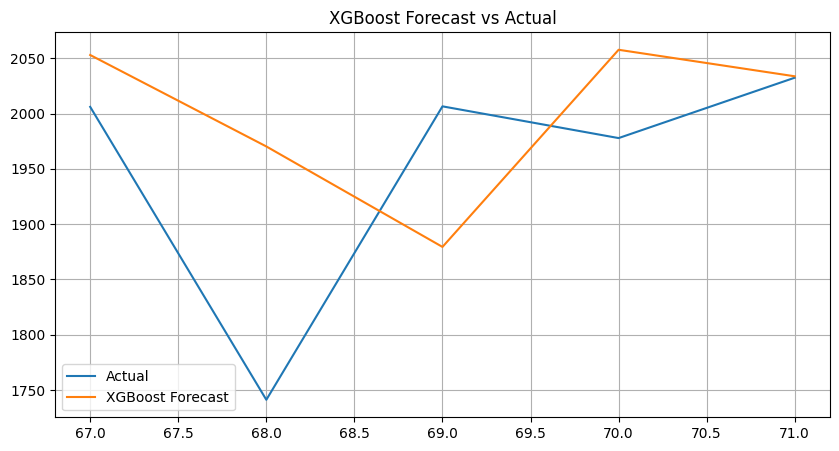

         Actual     Forecast
67  2006.155770  2053.069336
68  1741.154538  1970.339844
69  2006.622124  1879.450684
70  1977.913125  2057.803711
71  2032.539621  2033.815308


In [113]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Step 1: Lag Feature Engineering ---
df_ml = df_monthly_short_term_final[['Production_TBPD']].copy()
for lag in range(1, 13):  # 12 lags for seasonality
    df_ml[f'lag_{lag}'] = df_ml['Production_TBPD'].shift(lag)

df_ml.dropna(inplace=True)

# --- Step 2: Train-Test Split ---
X = df_ml.drop('Production_TBPD', axis=1)
y = df_ml['Production_TBPD']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=5)

# --- Step 3: Fit XGBoost ---
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)

# --- Step 4: Forecast & Evaluate ---
y_pred = model_xgb.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='XGBoost Forecast')
plt.title("XGBoost Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

# Optionally show forecast values
forecast_df = pd.DataFrame({'Actual': y_test, 'Forecast': y_pred}, index=y_test.index)
print(forecast_df)


       Period  Forecasted Production_TBPD XGBoost
0  2025-01-01                         2048.520996
1  2025-02-01                         2020.510986
2  2025-03-01                         2086.930420
3  2025-04-01                         2068.738037
4  2025-05-01                         1966.192871
5  2025-06-01                         1976.620850
6  2025-07-01                         2084.684570
7  2025-08-01                         2005.950928
8  2025-09-01                         1742.051270
9  2025-10-01                         2006.622070
10 2025-11-01                         1977.912476
11 2025-12-01                         2032.893555


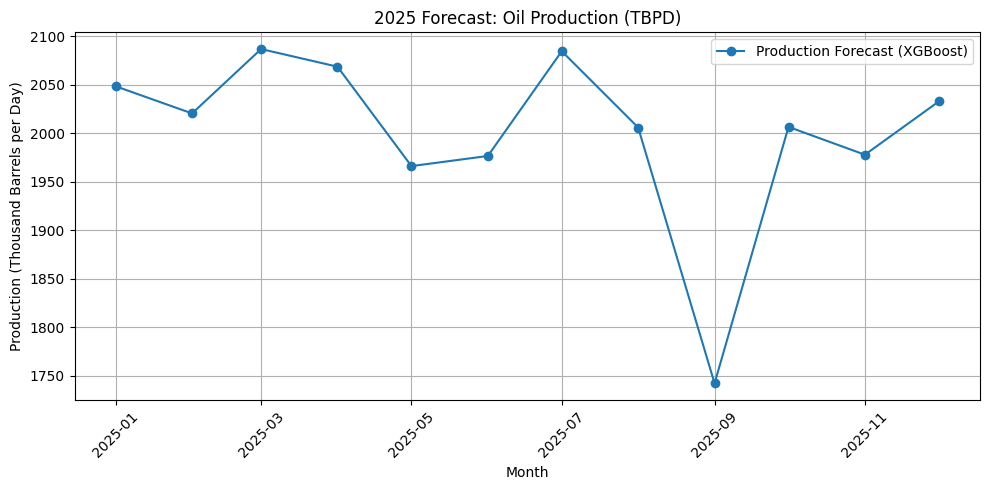

In [126]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Step 1: Load your dataset (assuming it's already a DataFrame)
df_xgboost = df_monthly_short_term_final.copy()

# Drop irrelevant columns (keep only 'Period' and 'Production_TBPD')
df_xgboost = df_xgboost[['Period', 'Production_TBPD', 'Monthly FX Returns',
                          'Oslo Monthly Returns', 'Overnight Lending Rate',
                          'Policy Rate']]

# Step 2: Feature engineering
df_xgboost['Month'] = df_xgboost['Period'].dt.month
df_xgboost['Year'] = df_xgboost['Period'].dt.year

# Lag feature for temporal modeling
df_xgboost['Lag1_Production'] = df_xgboost['Production_TBPD'].shift(1)
df_xgboost['Lag1_Production'] = pd.to_numeric(df_xgboost['Lag1_Production'], errors='coerce')

# Drop rows with NaNs due to lagging
df_xgboost = df_xgboost.dropna()

# Step 3: Prepare features and target
X = df_xgboost[['Monthly FX Returns', 'Oslo Monthly Returns', 'Overnight Lending Rate',
                'Policy Rate', 'Month', 'Lag1_Production']]
y = df_xgboost['Production_TBPD']

# Step 4: Train XGBoost model
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 5: Forecast for 2025
last_row = df_xgboost.iloc[-1].copy()
future_data = []

for i in range(1, 13):
    month = i
    fx_return = df_xgboost['Monthly FX Returns'].iloc[-12 + i - 1]  # replicate 2024 pattern
    oslo_return = df_xgboost['Oslo Monthly Returns'].iloc[-12 + i - 1]
    overnight = 5.5
    policy = 4.5
    lag_prod = last_row['Production_TBPD']

    row = [fx_return, oslo_return, overnight, policy, month, lag_prod]
    future_data.append(row)

    pred_prod = model.predict([row])[0]

    # Update lag for next forecast step
    last_row['Production_TBPD'] = pred_prod

# Step 6: Compile results
df_xgboost_forecast = pd.DataFrame(future_data, columns=X.columns)
df_xgboost_forecast['Forecasted Production_TBPD XGBoost'] = model.predict(df_xgboost_forecast[X.columns])
df_xgboost_forecast['Period'] = pd.date_range(start="2025-01-01", periods=12, freq='MS')

# Keep only the 'Period' and forecasted production column in the final output
df_xgboost_forecast_final = df_xgboost_forecast[['Period', 'Forecasted Production_TBPD XGBoost']]

# Display forecast
print(df_xgboost_forecast_final)

# Optional: Plot forecast
plt.figure(figsize=(10, 5))
plt.plot(df_xgboost_forecast_final['Period'], df_xgboost_forecast_final['Forecasted Production_TBPD XGBoost'], marker='o', label='Production Forecast (XGBoost)')
plt.title("2025 Forecast: Oil Production (TBPD)")
plt.xlabel("Month")
plt.ylabel("Production (Thousand Barrels per Day)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### **LSTM Implementation**

       Period  Forecasted Production_TBPD LSTM
0  2025-01-01                      2021.081843
1  2025-02-01                      2040.299229
2  2025-03-01                      2060.749379
3  2025-04-01                      2081.198547
4  2025-05-01                      2098.273446
5  2025-06-01                      2111.425865
6  2025-07-01                      2129.387641
7  2025-08-01                      2147.240407
8  2025-09-01                      2152.708072
9  2025-10-01                      2160.829852
10 2025-11-01                      2170.890639
11 2025-12-01                      2174.503325


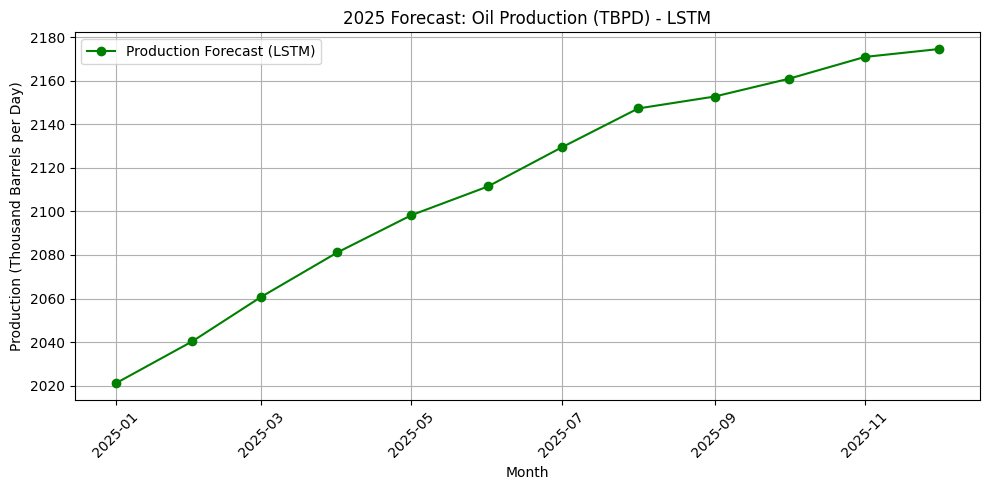

In [127]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Step 1: Prepare Data
df_lstm = df_xgboost.copy()
df_lstm = df_lstm[['Period', 'Monthly FX Returns', 'Oslo Monthly Returns',
                   'Overnight Lending Rate', 'Policy Rate', 'Month',
                   'Lag1_Production', 'Production_TBPD']]

# Scale the features
feature_cols = ['Monthly FX Returns', 'Oslo Monthly Returns', 'Overnight Lending Rate',
                'Policy Rate', 'Month', 'Lag1_Production']
target_col = 'Production_TBPD'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df_lstm[feature_cols])
y_scaled = scaler_y.fit_transform(df_lstm[[target_col]])

# Step 2: Create sequences
X_seq, y_seq = [], []
lookback = 12

for i in range(lookback, len(df_lstm)):
    X_seq.append(X_scaled[i-lookback:i])
    y_seq.append(y_scaled[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Step 3: Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(lookback, len(feature_cols))))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq, y_seq, epochs=100, verbose=0)

# Step 4: Forecasting 2025 (12 steps ahead)
last_data = X_scaled[-lookback:].copy()
forecast_scaled = []

for i in range(12):
    input_seq = last_data.reshape((1, lookback, len(feature_cols)))
    pred = model_lstm.predict(input_seq, verbose=0)[0]
    forecast_scaled.append(pred)

    # Create next step input using the predicted production as Lag1_Production
    next_input = last_data[-1].copy()
    next_input[-1] = pred  # Update Lag1_Production
    last_data = np.vstack((last_data[1:], next_input))

# Inverse scale predictions
forecast_prod = scaler_y.inverse_transform(forecast_scaled)

# Step 5: Create forecast DataFrame
df_lstm_forecast = pd.DataFrame({
    'Period': pd.date_range(start="2025-01-01", periods=12, freq='MS'),
    'Forecasted Production_TBPD LSTM': forecast_prod.flatten()
})

# Display results
print(df_lstm_forecast)

# Optional: Plot
plt.figure(figsize=(10, 5))
plt.plot(df_lstm_forecast['Period'], df_lstm_forecast['Forecasted Production_TBPD LSTM'], marker='o', label='Production Forecast (LSTM)', color='green')
plt.title("2025 Forecast: Oil Production (TBPD) - LSTM")
plt.xlabel("Month")
plt.ylabel("Production (Thousand Barrels per Day)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### **Merging the Results**

In [128]:
forecast_SARIMA_df['Period'] = pd.to_datetime(forecast_SARIMA_df['Period'])
df_xgboost_forecast_final['Period'] = pd.to_datetime(df_xgboost_forecast_final['Period'])
df_lstm_forecast['Period'] = pd.to_datetime(df_lstm_forecast['Period'])

forecast_SARIMA_df['Period'] = forecast_SARIMA_df['Period'].dt.normalize()
df_xgboost_forecast_final['Period'] = df_xgboost_forecast_final['Period'].dt.normalize()
df_lstm_forecast['Period'] = df_lstm_forecast['Period'].dt.normalize()

print(forecast_SARIMA_df['Period'].head())
print(df_xgboost_forecast_final['Period'].head())
print(df_lstm_forecast['Period'].head())


0   2025-01-01
1   2025-02-01
2   2025-03-01
3   2025-04-01
4   2025-05-01
Name: Period, dtype: datetime64[ns]
0   2025-01-01
1   2025-02-01
2   2025-03-01
3   2025-04-01
4   2025-05-01
Name: Period, dtype: datetime64[ns]
0   2025-01-01
1   2025-02-01
2   2025-03-01
3   2025-04-01
4   2025-05-01
Name: Period, dtype: datetime64[ns]


In [129]:
df_xgboost_forecast_final

Period  Forecasted Production_TBPD XGBoost
0  2025-01-01                         2048.520996
1  2025-02-01                         2020.510986
2  2025-03-01                         2086.930420
3  2025-04-01                         2068.738037
4  2025-05-01                         1966.192871
5  2025-06-01                         1976.620850
6  2025-07-01                         2084.684570
7  2025-08-01                         2005.950928
8  2025-09-01                         1742.051270
9  2025-10-01                         2006.622070
10 2025-11-01                         1977.912476
11 2025-12-01                         2032.893555

In [130]:
df_short_term_forecasted = pd.merge(forecast_SARIMA_df, df_xgboost_forecast_final, on='Period', how='inner')
df_short_term_forecasted = pd.merge(df_short_term_forecasted, df_lstm_forecast, on='Period', how='inner')

print(df_short_term_forecasted)

       Period  Forecasted_Production_TBPD SARIMA  \
0  2025-01-01                        2037.410030   
1  2025-02-01                        2045.804322   
2  2025-03-01                        2102.020301   
3  2025-04-01                        2089.565192   
4  2025-05-01                        2045.155663   
5  2025-06-01                        2053.525211   
6  2025-07-01                        2099.619371   
7  2025-08-01                        2055.997304   
8  2025-09-01                        1895.748410   
9  2025-10-01                        2027.864603   
10 2025-11-01                        2085.962453   
11 2025-12-01                        2162.119454   

    Forecasted Production_TBPD XGBoost  Forecasted Production_TBPD LSTM  
0                          2048.520996                      2021.081843  
1                          2020.510986                      2040.299229  
2                          2086.930420                      2060.749379  
3                          

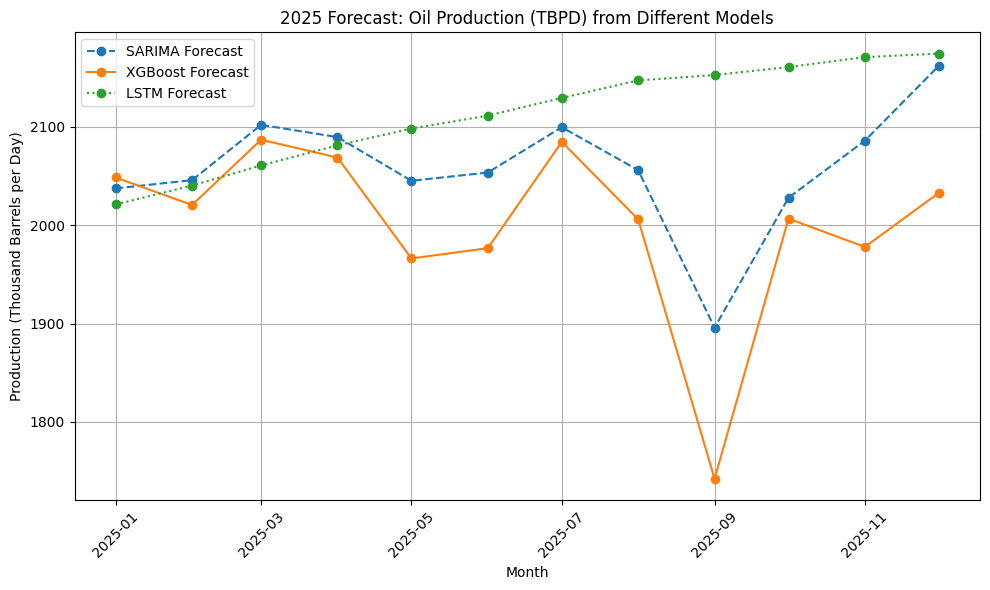

In [131]:
import matplotlib.pyplot as plt

# Assuming 'df_short_term_forecasted' is already available as a DataFrame
# Plotting the forecast values from SARIMA, XGBoost, and LSTM
plt.figure(figsize=(10, 6))

plt.plot(df_short_term_forecasted['Period'], df_short_term_forecasted['Forecasted_Production_TBPD SARIMA'], marker='o', label='SARIMA Forecast', linestyle='--')
plt.plot(df_short_term_forecasted['Period'], df_short_term_forecasted['Forecasted Production_TBPD XGBoost'], marker='o', label='XGBoost Forecast', linestyle='-')
plt.plot(df_short_term_forecasted['Period'], df_short_term_forecasted['Forecasted Production_TBPD LSTM'], marker='o', label='LSTM Forecast', linestyle=':')

# Adding labels and title
plt.title("2025 Forecast: Oil Production (TBPD) from Different Models")
plt.xlabel("Month")
plt.ylabel("Production (Thousand Barrels per Day)")
plt.legend()

# Displaying grid and improving layout
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


**Analyze the chart above**

The code performs time series forecasting of Norway's oil production for 2025 using three different models: SARIMA, XGBoost, and LSTM. Let's break down the analysis:

**Data Preparation:**

1.  **Data Sources:** The code integrates various data sources, including oil production data, Oslo stock market returns, and NOK/USD exchange rate data.
2.  **Data Cleaning & Feature Engineering:**  The code performs crucial data cleaning, handling missing values, and creating lagged features.  Lagged features are previous time steps' values, which help capture time dependencies in the data.  Monthly returns, FX returns and interest rates are used as exogenous variables in the models.
3.  **Data Transformation:** The code converts daily data to monthly returns and merges different datasets based on time periods. Dates are normalized.


**Modeling:**

1.  **SARIMA:**  A SARIMA (Seasonal Autoregressive Integrated Moving Average) model is applied.  This model accounts for seasonality and trends in time series data. The model is fitted to training data from 2019-2023 and used to predict the production in 2024. The forecast is evaluated against actual data. Then a forecast for 2025 is generated and plotted.

2.  **XGBoost:**  A gradient boosting model (XGBoost) is used for forecasting. The code creates lagged variables for the model training and applies feature engineering to potentially improve forecasting accuracy.  The model is used to predict monthly oil production for 2025.

3.  **LSTM:** A Long Short-Term Memory (LSTM) network, a type of recurrent neural network, is utilized. This model is designed for sequences of data and often performs well on time series data. Feature scaling is performed before input into the LSTM network. The model is then used to predict the oil production in 2025.


**Evaluation and Visualization:**

1.  **Model Evaluation (SARIMA):**  The code calculates the Mean Absolute Error (MAE) for the 2024 SARIMA forecast to evaluate its performance against the actual values.
2. **Combined Plots:** A final plot compares the 2025 forecasts of all three models.


**Overall:**

The notebook demonstrates a comprehensive approach to time series forecasting using multiple models.  By combining different models and comparing their outputs, the analysis aims to provide a more robust prediction of Norway's oil production in 2025.

# **Long Term Oil Production**

We will focus on forecasting Oil production for next 5-Years from 2025 to 2029 based on the historical Patterns. We will use all the data that we have collected through data pipeline

## **EDA**

*1.0 Converting daily Oil prices to Yearly from 1990 to 2024 only for UK Brent Crude Oil which is the baseline for Norway Oil*

In [35]:
import pandas as pd

# Ensure 'period' is in datetime format
df_oil_prices_historical['period'] = pd.to_datetime(df_oil_prices_historical['period'], errors='coerce')

# Filter for 2019–2024 and UK Brent Crude Oil
df_filtered = df_oil_prices_historical[
    (df_oil_prices_historical['period'].dt.year >= 1990) &
    (df_oil_prices_historical['period'].dt.year <= 2024) &
    (df_oil_prices_historical['product-name'] == 'UK Brent Crude Oil')
].copy()

# Convert 'value' to numeric safely
df_filtered.loc[:, 'value'] = pd.to_numeric(df_filtered['value'], errors='coerce')

# Drop NaNs
df_filtered = df_filtered.dropna(subset=['value'])

# Group by year-month and average
df_filtered['YearMonth'] = df_filtered['period'].dt.to_period('Y')
df_yearly_long_term = df_filtered.groupby('YearMonth')['value'].mean().reset_index()

# Rename columns
df_yearly_long_term.columns = ['Period', 'Yearly Average Value']
df_yearly_long_term['Period'] = df_yearly_long_term['Period'].dt.to_timestamp()

# Final output
df_yearly_long_term.head()

Period Yearly Average Value
0 1990-01-01            23.761445
1 1991-01-01            20.041128
2 1992-01-01            19.319728
3 1993-01-01            17.013413
4 1994-01-01            15.856389

*2.0 Taking the Yearly production data and adding it to the short term dataframe*

In [36]:
df_monthly_production_eia.head()

Date  Production_TBPD
383 1993-01-01           2089.0
382 1993-02-01           2229.0
381 1993-03-01           2435.0
380 1993-04-01           2447.0
379 1993-05-01           2367.0

In [45]:
import pandas as pd

df = df_monthly_production_eia

# Assuming your DataFrame is named df and the datetime column is 'Date'
df['Date'] = pd.to_datetime(df['Date'])  # Ensure datetime format
df = df.sort_values('Date')  # Ensure chronological order
df = df.set_index('Date')    # Set Date as index

# Resample to yearly frequency using average monthly production
yearly_df = df['Production_TBPD'].resample('Y').mean().reset_index()

# Convert 'Date' to just year (int)
yearly_df['Year'] = yearly_df['Date'].dt.year
yearly_df = yearly_df.drop(columns='Date')

# Reorder columns
yearly_df = yearly_df[['Year', 'Production_TBPD']]

print(yearly_df.tail(25))

    Year  Production_TBPD
7   2000      3330.362167
8   2001      3402.227417
9   2002      3322.536167
10  2003      3252.804250
11  2004      3189.070417
12  2005      2972.161083
13  2006      2782.282833
14  2007      2561.052000
15  2008      2463.291500
16  2009      2352.344000
17  2010      2142.666433
18  2011      2047.374267
19  2012      1922.020633
20  2013      1841.311800
21  2014      1892.944100
22  2015      1952.004267
23  2016      1998.794733
24  2017      1975.093629
25  2018      1858.288169
26  2019      1742.123093
27  2020      2007.023174
28  2021      2030.811611
29  2022      1906.679201
30  2023      2024.308373
31  2024      2006.256177


<ipython-input-45-2ac2318662cc>:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_df = df['Production_TBPD'].resample('Y').mean().reset_index()


In [49]:

df_yearly_long_term['Period'] = pd.to_datetime(df_yearly_long_term['Period'])

# Extract 'Year' from the Period
df_yearly_long_term['Year'] = df_yearly_long_term['Period'].dt.year


# Now merge on 'Year'
df_yearly_long_term2 = pd.merge(df_yearly_long_term, yearly_df, on='Year', how='left')

# Drop extra 'Period_y' column and rename as needed
df_yearly_long_term2.drop(columns=['Period_y'], inplace=True, errors='ignore')
df_yearly_long_term2.rename(columns={'Period_x': 'Period'}, inplace=True, errors='ignore')

# Final result
print(df_yearly_long_term2.head(73))

       Period Yearly Average Value  Year  Production_TBPD
0  1990-01-01            23.761445  1990              NaN
1  1991-01-01            20.041128  1991              NaN
2  1992-01-01            19.319728  1992              NaN
3  1993-01-01            17.013413  1993      2375.083333
4  1994-01-01            15.856389  1994      2685.346167
5  1995-01-01             17.01585  1995      2892.173417
6  1996-01-01            20.639803  1996      3223.473000
7  1997-01-01            19.108508  1997      3263.486417
8  1998-01-01            12.758103  1998      3124.410833
9  1999-01-01            17.901566  1999      3121.645583
10 2000-01-01            28.660672  2000      3330.362167
11 2001-01-01             24.45572  2001      3402.227417
12 2002-01-01            24.993255  2002      3322.536167
13 2003-01-01            28.850814  2003      3252.804250
14 2004-01-01            38.259693  2004      3189.070417
15 2005-01-01            54.574553  2005      2972.161083
16 2006-01-01 

*3.0 Using Oil Rent data which was previously uploaded through excel*

In [50]:
df_oil_rent.head()

Country Name Country Code        Indicator Name  \
0                        Aruba          ABW  Oil rents (% of GDP)   
1  Africa Eastern and Southern          AFE  Oil rents (% of GDP)   
2                  Afghanistan          AFG  Oil rents (% of GDP)   
3   Africa Western and Central          AFW  Oil rents (% of GDP)   
4                       Angola          AGO  Oil rents (% of GDP)   

      Indicator Code  1960  1961  1962  1963  1964  1965  ...       2014  \
0  NY.GDP.PETR.RT.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   0.000000   
1  NY.GDP.PETR.RT.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   3.858704   
2  NY.GDP.PETR.RT.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   0.040744   
3  NY.GDP.PETR.RT.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   6.642740   
4  NY.GDP.PETR.RT.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...  21.736607   

        2015       2016       2017       2018       2019       2020  \
0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1   1.565946   1.387176   2.064717   2.740083   2.223498   1.126503   
2   0.013636   0.009445   0.013427   0.018854   0.012777   0.005178   
3   2.666028   2.435413   4.602161   6.534543   5.690815   2.895055   
4  12.718730  19.748399  24.711006  30.730403  27.504829  18.571960   

        2021  2022  2023  
0   0.000000   NaN   NaN  
1   2.040738   NaN   NaN  
2   0.017870   NaN   NaN  
3   5.221742   NaN   NaN  
4  28.274440   NaN   NaN  

[5 rows x 68 columns]

In [51]:
# Step 1: Filter for Norway only
norway_data = df_oil_rent[df_oil_rent['Country Name'] == 'Norway']

# Step 2: Select columns for years 1990 to 2024
year_columns = [str(year) for year in range(1990, 2024)]
norway_data_filtered = norway_data[year_columns]

# Step 3: Transpose the data
norway_transposed = norway_data_filtered.T

# Step 4: Rename column and reset index
norway_transposed.columns = ['Oil Rents (% of GDP)']
norway_transposed.index.name = 'Year'
norway_transposed.reset_index(inplace=True)

# Display the final result
print(norway_transposed)


    Year  Oil Rents (% of GDP)
0   1990              7.387786
1   1991              4.085956
2   1992              4.729888
3   1993              5.262523
4   1994              5.007560
5   1995              5.031401
6   1996              7.373756
7   1997              5.891309
8   1998              1.836002
9   1999              5.224320
10  2000             11.563574
11  2001              8.323849
12  2002              7.512373
13  2003              7.335853
14  2004              8.358726
15  2005              9.626795
16  2006              9.195033
17  2007              7.982879
18  2008              9.873525
19  2009              5.992639
20  2010              5.617994
21  2011              7.504436
22  2012              6.467131
23  2013              5.549265
24  2014              5.542336
25  2015              3.146066
26  2016              2.604603
27  2017              3.635414
28  2018              4.967222
29  2019              4.538003
30  2020              3.229818
31  2021

In [52]:
# Merge on 'Year'

norway_transposed['Year'] = norway_transposed['Year'].astype(int)
df_yearly_long_term2['Year'] = df_yearly_long_term2['Year'].astype(int)

# Step 2: Merge the two DataFrames on 'Year'
df_yearly_long_term3 = pd.merge(df_yearly_long_term2, norway_transposed, on='Year', how='left')

# Step 3: Display the result
print(df_yearly_long_term3.head(70))

       Period Yearly Average Value  Year  Production_TBPD  \
0  1990-01-01            23.761445  1990              NaN   
1  1991-01-01            20.041128  1991              NaN   
2  1992-01-01            19.319728  1992              NaN   
3  1993-01-01            17.013413  1993      2375.083333   
4  1994-01-01            15.856389  1994      2685.346167   
5  1995-01-01             17.01585  1995      2892.173417   
6  1996-01-01            20.639803  1996      3223.473000   
7  1997-01-01            19.108508  1997      3263.486417   
8  1998-01-01            12.758103  1998      3124.410833   
9  1999-01-01            17.901566  1999      3121.645583   
10 2000-01-01            28.660672  2000      3330.362167   
11 2001-01-01             24.45572  2001      3402.227417   
12 2002-01-01            24.993255  2002      3322.536167   
13 2003-01-01            28.850814  2003      3252.804250   
14 2004-01-01            38.259693  2004      3189.070417   
15 2005-01-01           

*4.0 Using the GDP Data for forecasting*

In [53]:
GDP_Data

Year  GDP_BDOLPPP GDP_Growth_Actual
44  1980     135.4461               N/A
43  1981     137.6109             1.60%
42  1982     137.9349             0.24%
41  1983     143.4151             3.97%
40  1984     152.0951             6.05%
39  1985     160.5415             5.55%
38  1986     167.0307             4.04%
37  1987     169.9597             1.75%
36  1988     169.5260            -0.26%
35  1989     171.2861             1.04%
34  1990     174.5960             1.93%
33  1991     179.9812             3.08%
32  1992     186.4146             3.57%
31  1993     191.7184             2.85%
30  1994     201.4104             5.06%
29  1995     209.7802             4.16%
28  1996     220.3278             5.03%
27  1997     231.9712             5.28%
26  1998     238.1619             2.67%
25  1999     243.0967             2.07%
24  2000     251.1649             3.32%
23  2001     256.3568             2.07%
22  2002     259.8883             1.38%
21  2003     262.3440             0.94%
20  2004     272.8761             4.01%
19  2005     280.2031             2.69%
18  2006     287.1002             2.46%
17  2007     295.4663             2.91%
16  2008     296.8903             0.48%
15  2009     291.1295            -1.94%
14  2010     293.4209             0.79%
13  2011     296.6651             1.11%
12  2012     304.7284             2.72%
11  2013     307.8249             1.02%
10  2014     314.1296             2.05%
9   2015     319.9640             1.86%
8   2016     322.1548             0.68%
7   2017     331.5718             2.92%
6   2018     335.5354             1.20%
5   2019     339.2623             1.11%
4   2020     333.0393            -1.83%
3   2021     346.4958             4.04%
2   2022     357.7640             3.25%
1   2023     358.4058             0.18%
0   2024     365.9415             2.10%

In [54]:
# Merge on 'Year'

GDP_Data['Year'] = GDP_Data['Year'].astype(int)
df_yearly_long_term3['Year'] = df_yearly_long_term3['Year'].astype(int)

# Step 2: Merge the two DataFrames on 'Year'
df_yearly_long_term4 = pd.merge(df_yearly_long_term3, GDP_Data, on='Year', how='left')

# Step 3: Display the result
print(df_yearly_long_term4.head(70))

       Period Yearly Average Value  Year  Production_TBPD  \
0  1990-01-01            23.761445  1990              NaN   
1  1991-01-01            20.041128  1991              NaN   
2  1992-01-01            19.319728  1992              NaN   
3  1993-01-01            17.013413  1993      2375.083333   
4  1994-01-01            15.856389  1994      2685.346167   
5  1995-01-01             17.01585  1995      2892.173417   
6  1996-01-01            20.639803  1996      3223.473000   
7  1997-01-01            19.108508  1997      3263.486417   
8  1998-01-01            12.758103  1998      3124.410833   
9  1999-01-01            17.901566  1999      3121.645583   
10 2000-01-01            28.660672  2000      3330.362167   
11 2001-01-01             24.45572  2001      3402.227417   
12 2002-01-01            24.993255  2002      3322.536167   
13 2003-01-01            28.850814  2003      3252.804250   
14 2004-01-01            38.259693  2004      3189.070417   
15 2005-01-01           

*5.0 Using the Oslo Index Return Data for forecasting*

In [55]:
df_oslo_return

Price             Close         High          Low         Open Volume
Ticker           OBX.OL       OBX.OL       OBX.OL       OBX.OL OBX.OL
Date                                                                 
2004-09-27   184.210007   184.210007   183.600006   183.720001      0
2004-09-28   184.869995   185.470001   184.169998   184.199997      0
2004-09-29   185.050003   186.580002   184.710007   185.080002      0
2004-09-30   185.279999   185.940002   184.770004   185.050003      0
2004-10-01   188.830002   188.830002   185.380005   185.380005      0
...                 ...          ...          ...          ...    ...
2025-03-27  1459.180054  1469.339966  1446.239990  1469.339966      0
2025-03-28  1437.930054  1459.380005  1434.930054  1459.380005      0
2025-03-31  1444.369995  1446.760010  1423.689941  1438.030029      0
2025-04-01  1445.949951  1455.859985  1444.650024  1444.650024      0
2025-04-02  1426.349976  1451.650024  1424.030029  1445.949951      0

[5148 rows x 5 columns]

In [56]:
import pandas as pd

# Step 1: Copy original dataframe
df_filtered = df_oslo_return.copy()

# Step 2: Ensure index is datetime
df_filtered.index = pd.to_datetime(df_filtered.index)

# Step 3: Filter data between 2019 and 2024
df_filtered = df_filtered[(df_filtered.index >= '1985-12-01') & (df_filtered.index <= '2024-12-31')]

# Step 4: Resample to month-end and get last closing price of each month
monthly_close = df_filtered['Close'].resample('Y').last()

# Step 5: Calculate monthly returns
monthly_returns = monthly_close.pct_change().dropna()

# Step 6: Construct final DataFrame
Oslo_result_df = pd.DataFrame({
    'Period': monthly_returns.index.to_period('M').astype(str),
    'Oslo Monthly Returns': monthly_returns.values.flatten()  # Ensure it's 1D
})

# Show output
print(Oslo_result_df.head(72))


     Period  Oslo Monthly Returns
0   2005-12              0.410281
1   2006-12              0.336296
2   2007-12              0.136548
3   2008-12             -0.528217
4   2009-12              0.704012
5   2010-12              0.180007
6   2011-12             -0.106893
7   2012-12              0.147371
8   2013-12              0.227346
9   2014-12              0.039914
10  2015-12              0.029216
11  2016-12              0.146146
12  2017-12              0.202428
13  2018-12             -0.004550
14  2019-12              0.140556
15  2020-12              0.018391
16  2021-12              0.244242
17  2022-12              0.019998
18  2023-12              0.095257
19  2024-12              0.113961


<ipython-input-56-2f3055b2816a>:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  monthly_close = df_filtered['Close'].resample('Y').last()


In [58]:
# Step 1: Ensure Period is in datetime format
Oslo_result_df['Period'] = pd.to_datetime(Oslo_result_df['Period'], format='%Y-%m')

# Step 2: Extract Year from Period
Oslo_result_df['Year'] = Oslo_result_df['Period'].dt.year

# Step 3: Merge with df_yearly_long_term3 on 'Year'
df_yearly_long_term_final = pd.merge(df_yearly_long_term4, Oslo_result_df[['Year', 'Oslo Monthly Returns']], on='Year', how='left')

# Step 4: Preview the result
print(df_yearly_long_term_final.head(80))

       Period Yearly Average Value  Year  Production_TBPD  \
0  1990-01-01            23.761445  1990              NaN   
1  1991-01-01            20.041128  1991              NaN   
2  1992-01-01            19.319728  1992              NaN   
3  1993-01-01            17.013413  1993      2375.083333   
4  1994-01-01            15.856389  1994      2685.346167   
5  1995-01-01             17.01585  1995      2892.173417   
6  1996-01-01            20.639803  1996      3223.473000   
7  1997-01-01            19.108508  1997      3263.486417   
8  1998-01-01            12.758103  1998      3124.410833   
9  1999-01-01            17.901566  1999      3121.645583   
10 2000-01-01            28.660672  2000      3330.362167   
11 2001-01-01             24.45572  2001      3402.227417   
12 2002-01-01            24.993255  2002      3322.536167   
13 2003-01-01            28.850814  2003      3252.804250   
14 2004-01-01            38.259693  2004      3189.070417   
15 2005-01-01           

## **Profiling and Modeling**

### **Showing Data Profile using YData**

In [59]:
!pip install ydata_profiling
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

In [61]:
# Generate data profiling report
profile = ProfileReport(df_yearly_long_term_final, explorative=True)
profile.to_file("data_profiling_report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:00<00:00, 39.54it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### **Data Cleaning**

            Yearly Average Value  Year  Production_TBPD  Oil Rents (% of GDP)  \
Period                                                                          
1990-01-01             23.761445  1990              NaN              7.387786   
1991-01-01             20.041128  1991              NaN              4.085956   
1992-01-01             19.319728  1992              NaN              4.729888   
1993-01-01             17.013413  1993      2375.083333              5.262523   
1994-01-01             15.856389  1994      2685.346167              5.007560   

            GDP_BDOLPPP  GDP_Growth_Actual  Oslo Monthly Returns  
Period                                                            
1990-01-01     174.5960               1.93                   NaN  
1991-01-01     179.9812               3.08                   NaN  
1992-01-01     186.4146               3.57                   NaN  
1993-01-01     191.7184               2.85                   NaN  
1994-01-01     201.4104       

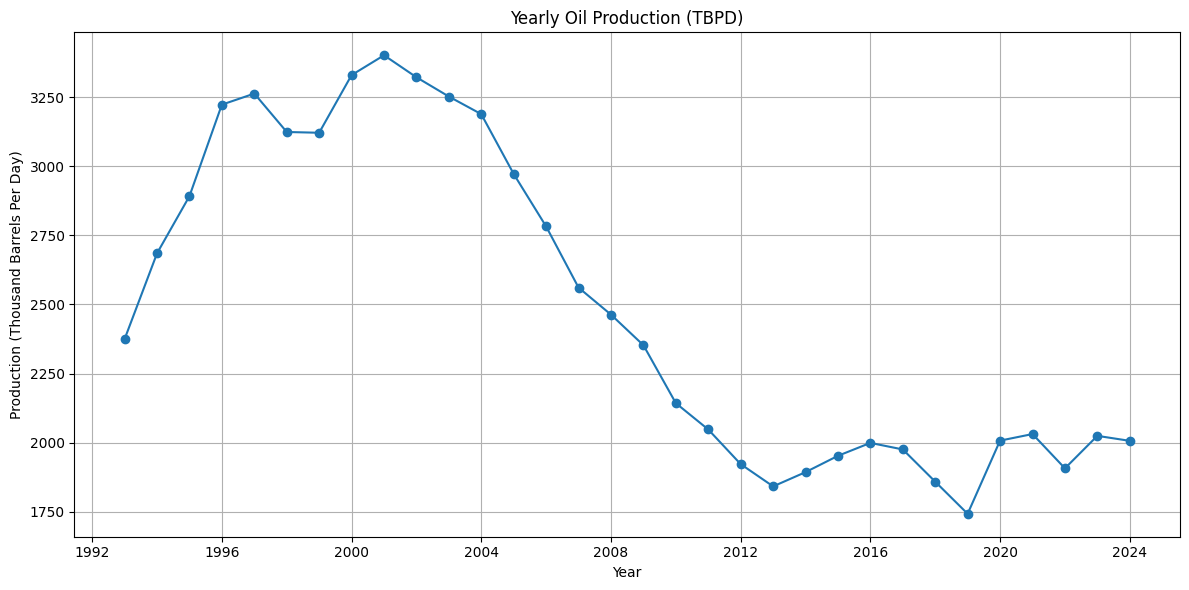

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make a copy to avoid modifying the original DataFrame
df_yearly_long_term_final_clean = df_yearly_long_term_final.copy()

# Step 1: Convert 'Period' column to datetime format
if 'Period' in df_yearly_long_term_final_clean.columns:
    df_yearly_long_term_final_clean['Period'] = pd.to_datetime(df_yearly_long_term_final_clean['Period'])

# Step 2: Convert 'GDP_Growth_Actual' to float (removing % symbol)
if 'GDP_Growth_Actual' in df_yearly_long_term_final_clean.columns:
    df_yearly_long_term_final_clean['GDP_Growth_Actual'] = df_yearly_long_term_final_clean['GDP_Growth_Actual'].astype(str)
    df_yearly_long_term_final_clean['GDP_Growth_Actual'] = df_yearly_long_term_final_clean['GDP_Growth_Actual'].str.replace('%', '', regex=False)
    df_yearly_long_term_final_clean['GDP_Growth_Actual'] = pd.to_numeric(df_yearly_long_term_final_clean['GDP_Growth_Actual'], errors='coerce')

# Step 3: Interpolate missing values in 'Production_TBPD' (1990–1992)
if 'Production_TBPD' in df_yearly_long_term_final_clean.columns:
    df_yearly_long_term_final_clean['Production_TBPD'] = df_yearly_long_term_final_clean['Production_TBPD'].interpolate(method='linear')

# Step 4: Forward fill for remaining missing values
df_yearly_long_term_final_clean.ffill(inplace=True)

# Step 5: Infer types for cleaner memory usage
df_yearly_long_term_final_clean.infer_objects(copy=False)

# Step 6: Set 'Period' as index (if not already)
if 'Period' in df_yearly_long_term_final_clean.columns:
    df_yearly_long_term_final_clean.set_index('Period', inplace=True)

# Optional: Sort index in case it's out of order
df_yearly_long_term_final_clean.sort_index(inplace=True)

# Preview the cleaned dataset
print(df_yearly_long_term_final_clean.head())

# Optional: Plot to visualize
plt.figure(figsize=(12, 6))
plt.plot(df_yearly_long_term_final_clean.index, df_yearly_long_term_final_clean['Production_TBPD'], marker='o')
plt.title('Yearly Oil Production (TBPD)')
plt.xlabel('Year')
plt.ylabel('Production (Thousand Barrels Per Day)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
import numpy as np
import pandas as pd

# If already indexed by 'Period', reset it temporarily
df = df_yearly_long_term_final_clean.copy()
if df.index.name == 'Period':
    df.reset_index(inplace=True)

# Ensure correct types
df['Period'] = pd.to_datetime(df['Period'], errors='coerce')
df['GDP_Growth_Actual'] = df['GDP_Growth_Actual'].astype(str).str.replace('%', '', regex=False)
df['GDP_Growth_Actual'] = pd.to_numeric(df['GDP_Growth_Actual'], errors='coerce')

# Replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Show problematic rows (for debugging)
print("🔍 Rows with NaNs or Infs in exog:")
print(df[df['GDP_Growth_Actual'].isna()])

# Now fill missing GDP values (if any)
df['GDP_Growth_Actual'].interpolate(method='linear', inplace=True)
df['GDP_Growth_Actual'].ffill(inplace=True)
df['GDP_Growth_Actual'].bfill(inplace=True)

# Final hard check
assert not df['GDP_Growth_Actual'].isna().any(), "There are still NaNs in GDP_Growth_Actual!"
assert not np.isinf(df['GDP_Growth_Actual']).any(), "There are still Inf values in GDP_Growth_Actual!"

# Reset and reindex if necessary
df.set_index('Period', inplace=True)

print("✅ GDP_Growth_Actual is fully clean now.")

🔍 Rows with NaNs or Infs in exog:
Empty DataFrame
Columns: [Period, Yearly Average Value, Year, Production_TBPD, Oil Rents (% of GDP), GDP_BDOLPPP, GDP_Growth_Actual, Oslo Monthly Returns]
Index: []
✅ GDP_Growth_Actual is fully clean now.


### **SARIMA Implementation**

NaNs in Production_TBPD: 0
NaNs in GDP_Growth_Actual: 0

ADF Statistic: -1.086998040846935
p-value: 0.7202289870465572


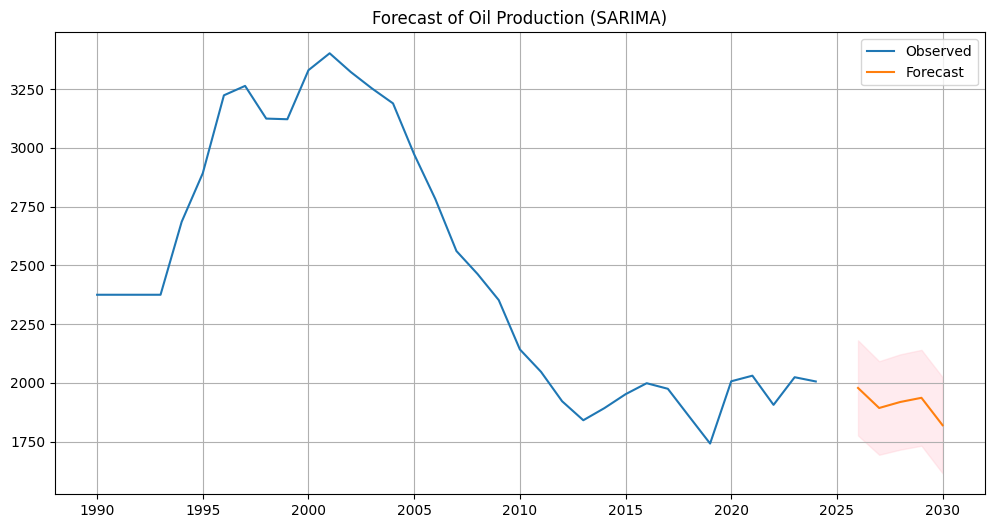


Forecasted Production (TBPD) for next 5 years:
            Forecasted_Production  Lower_CI  Upper_CI
2025-12-31                1978.71   1776.36   2181.07
2026-12-31                1893.41   1694.47   2092.35
2027-12-31                1918.98   1716.36   2121.60
2028-12-31                1936.76   1732.88   2140.65
2029-12-31                1820.05   1615.71   2024.39


In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# --- Step 1: Prepare Data ---
df = df_yearly_long_term_final_clean.copy()

# Ensure 'Period' is a column and datetime
if df.index.name == 'Period':
    df.reset_index(inplace=True)

df['Period'] = pd.to_datetime(df['Period'])
df.set_index('Period', inplace=True)

# Clean GDP Growth column
df['GDP_Growth_Actual'] = df['GDP_Growth_Actual'].apply(
    lambda x: str(x).replace('%', '') if pd.notnull(x) else x
).astype(float)

# Replace inf with NaN and fill
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Interpolate & Clean NaNs ---
df['Production_TBPD'] = df['Production_TBPD'].interpolate(method='linear')
df['Production_TBPD'] = df['Production_TBPD'].ffill()
df['Production_TBPD'] = df['Production_TBPD'].bfill()

df['GDP_Growth_Actual'] = df['GDP_Growth_Actual'].interpolate(method='linear')
df['GDP_Growth_Actual'] = df['GDP_Growth_Actual'].ffill()
df['GDP_Growth_Actual'] = df['GDP_Growth_Actual'].bfill()

# Final sanity check
print("NaNs in Production_TBPD:", df['Production_TBPD'].isna().sum())
print("NaNs in GDP_Growth_Actual:", df['GDP_Growth_Actual'].isna().sum())

# --- Step 2: ADF Test for Stationarity ---
result = adfuller(df['Production_TBPD'])
print("\nADF Statistic:", result[0])
print("p-value:", result[1])

# --- Step 3: Fit SARIMA with exogenous GDP ---
use_exog = True

if use_exog:
    exog = df[['GDP_Growth_Actual']].copy()
else:
    exog = None

model = SARIMAX(
    df['Production_TBPD'],
    exog=exog,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = model.fit()

# --- Step 4: Forecast ---
n_years = 5
future_years = pd.date_range(df.index[-1] + pd.DateOffset(years=1), periods=n_years, freq='Y')

if use_exog:
    future_exog = pd.DataFrame({
        'GDP_Growth_Actual': [df['GDP_Growth_Actual'].mean()] * n_years
    }, index=future_years)
else:
    future_exog = None

forecast = sarima_result.get_forecast(steps=n_years, exog=future_exog)
forecast_ci = forecast.conf_int()

# --- Step 5: Plot ---
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Production_TBPD'], label='Observed')
plt.plot(future_years, forecast.predicted_mean, label='Forecast')
plt.fill_between(future_years, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast of Oil Production (SARIMA)')
plt.legend()
plt.grid(True)
plt.show()

# --- Step 6: Print Forecasted Values ---
print("\nForecasted Production (TBPD) for next 5 years:")
forecast_table = pd.DataFrame({
    'Forecasted_Production': forecast.predicted_mean,
    'Lower_CI': forecast_ci.iloc[:, 0],
    'Upper_CI': forecast_ci.iloc[:, 1]
})
forecast_table.index = future_years
print(forecast_table.round(2))


**Interpretation:**

1. Volatility:The production trend is not linear — it shows alternating rises and falls, which may suggest:
  Economic or policy-related uncertainties (reflected via GDP Growth or

*   Economic or policy-related uncertainties (reflected via GDP Growth or seasonality).
*   A SARIMA model that is accounting for complex seasonal effects or shocks.


2. Overall Trend: There's no strong upward or downward trend, but a slight downward bias appears over the 5 years:

*   2025: 1978 TBPD
*   2029: 1820 TBPD

  That's ~8% drop over 5 years

3. Confidence Intervals: The prediction intervals (±200 TBPD) are fairly wide, indicating some uncertainty — especially for long-term predictions:

  For 2029, the production could realistically be anywhere between 1615 and 2024 TBPD.)






### **Monte Carlo with SARIMA**

SARIMA gives you a point estimate, but real-world production is affected by multiple uncertainties (like oil prices, GDP growth, rents, etc.). Monte Carlo simulation:

*  Helps model the uncertainty in forecasts.

*  Generates confidence intervals or percentile bands.




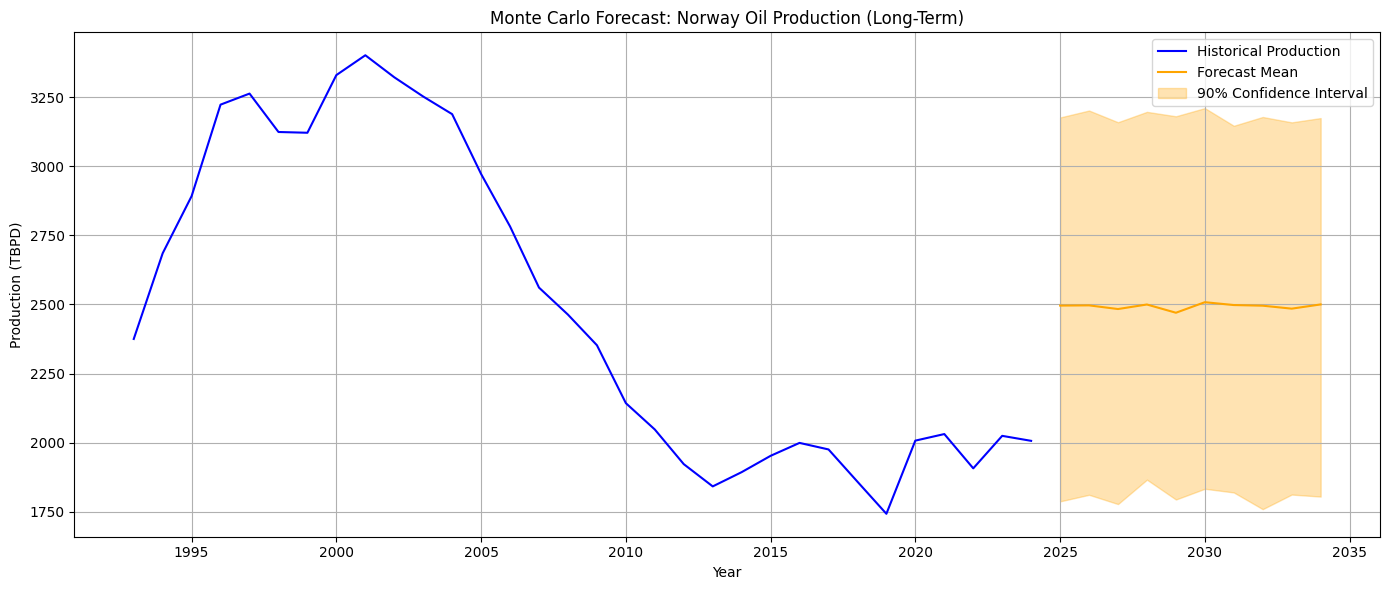

[Timestamp('2025-01-01 00:00:00'), Timestamp('2026-01-01 00:00:00'), Timestamp('2027-01-01 00:00:00'), Timestamp('2028-01-01 00:00:00'), Timestamp('2029-01-01 00:00:00'), Timestamp('2030-01-01 00:00:00'), Timestamp('2031-01-01 00:00:00'), Timestamp('2032-01-01 00:00:00'), Timestamp('2033-01-01 00:00:00'), Timestamp('2034-01-01 00:00:00')]


In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# ----- Step 1: Prepare Data -----
df = df_yearly_long_term_final.copy()

# Rename columns if necessary for clarity
df = df.rename(columns={
    'Year': 'Period',  # Change this only if your column is actually called 'Year'
    'Yearly Average Value': 'Price',
    'Production_TBPD': 'Production'
})

# Drop rows with missing values
df_model = df[['Period', 'Price', 'Production']].dropna()

# Convert Period to datetime (assumes Period is year, e.g., 2018)
df_model['Period'] = pd.to_datetime(df_model['Period'], format='%Y')

# Predictor (X) and Target (y)
X = df_model[['Price']]
y = df_model['Production']

# ----- Step 2: Fit Linear Regression -----
model = LinearRegression()
model.fit(X, y)

# ----- Step 3: Monte Carlo Simulation -----
n_simulations = 1000
forecast_years = 10
last_date = df_model['Period'].max()
future_price_mean = X.mean().values[0]
future_price_std = X.std().values[0]

# Simulate future forecasts
simulated_forecasts = np.zeros((forecast_years, n_simulations))

for i in range(n_simulations):
    future_prices = np.random.normal(loc=future_price_mean, scale=future_price_std, size=forecast_years)
    future_preds = model.predict(future_prices.reshape(-1, 1))
    simulated_forecasts[:, i] = future_preds

# ----- Step 4: Calculate Confidence Bands -----
forecast_mean = simulated_forecasts.mean(axis=1)
forecast_lower = np.percentile(simulated_forecasts, 5, axis=1)
forecast_upper = np.percentile(simulated_forecasts, 95, axis=1)

# Future dates for plotting
future_dates = [last_date + pd.DateOffset(years=i) for i in range(1, forecast_years + 1)]

# ----- Step 5: Plot -----
plt.figure(figsize=(14, 6))
sns.lineplot(x=df_model['Period'], y=df_model['Production'], label='Historical Production', color='blue')
sns.lineplot(x=future_dates, y=forecast_mean, label='Forecast Mean', color='orange')
plt.fill_between(future_dates, forecast_lower, forecast_upper, alpha=0.3, label='90% Confidence Interval', color='orange')
plt.title("Monte Carlo Forecast: Norway Oil Production (Long-Term)")
plt.ylabel("Production (TBPD)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Monte Carlo Simulation - Forecasted Production for each Year:
Year 1: Mean: 2510.07, Lower 5%: 1831.10, Upper 95%: 3163.45
Year 2: Mean: 2462.03, Lower 5%: 1770.88, Upper 95%: 3185.54
Year 3: Mean: 2489.60, Lower 5%: 1825.45, Upper 95%: 3197.06
Year 4: Mean: 2486.56, Lower 5%: 1779.83, Upper 95%: 3164.64
Year 5: Mean: 2483.15, Lower 5%: 1797.31, Upper 95%: 3149.01


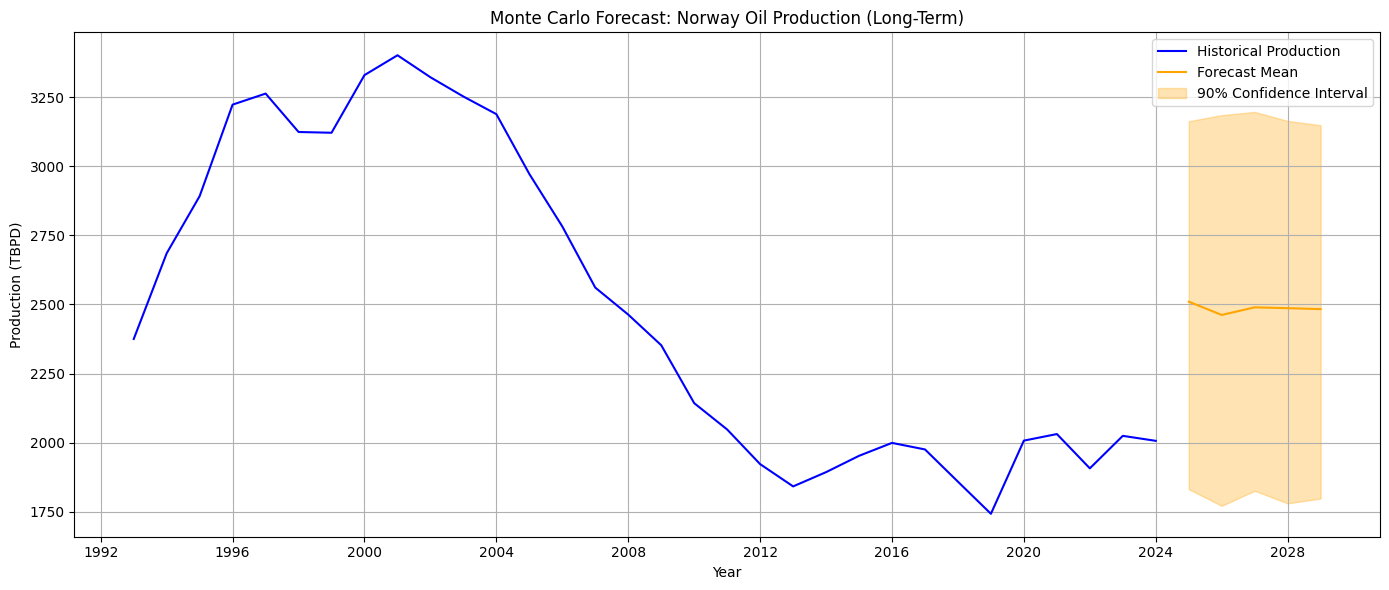

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# ----- Step 1: Prepare Data -----
df = df_yearly_long_term_final.copy()

# Rename columns if necessary for clarity
df = df.rename(columns={
    'Year': 'Period',  # Change this only if your column is actually called 'Year'
    'Yearly Average Value': 'Price',
    'Production_TBPD': 'Production'
})

# Drop rows with missing values
df_model = df[['Period', 'Price', 'Production']].dropna()

# Convert Period to datetime (assumes Period is year, e.g., 2018)
df_model['Period'] = pd.to_datetime(df_model['Period'], format='%Y')

# Predictor (X) and Target (y)
X = df_model[['Price']]
y = df_model['Production']

# ----- Step 2: Fit Linear Regression -----
model = LinearRegression()
model.fit(X, y)

# ----- Step 3: Monte Carlo Simulation -----
n_simulations = 1000
forecast_years = 5
last_date = df_model['Period'].max()
future_price_mean = X.mean().values[0]
future_price_std = X.std().values[0]

# Simulate future forecasts
simulated_forecasts = np.zeros((forecast_years, n_simulations))

for i in range(n_simulations):
    future_prices = np.random.normal(loc=future_price_mean, scale=future_price_std, size=forecast_years)
    future_preds = model.predict(future_prices.reshape(-1, 1))
    simulated_forecasts[:, i] = future_preds

# ----- Step 4: Calculate Confidence Bands -----
forecast_mean = simulated_forecasts.mean(axis=1)
forecast_lower = np.percentile(simulated_forecasts, 5, axis=1)
forecast_upper = np.percentile(simulated_forecasts, 95, axis=1)

# ----- Step 5: Print Simulated Outcomes -----
print("Monte Carlo Simulation - Forecasted Production for each Year:")

for i in range(forecast_years):
    print(f"Year {i + 1}: Mean: {forecast_mean[i]:.2f}, Lower 5%: {forecast_lower[i]:.2f}, Upper 95%: {forecast_upper[i]:.2f}")

# Future dates for plotting
future_dates = [last_date + pd.DateOffset(years=i) for i in range(1, forecast_years + 1)]

# ----- Step 6: Plot -----
plt.figure(figsize=(14, 6))
sns.lineplot(x=df_model['Period'], y=df_model['Production'], label='Historical Production', color='blue')
sns.lineplot(x=future_dates, y=forecast_mean, label='Forecast Mean', color='orange')
plt.fill_between(future_dates, forecast_lower, forecast_upper, alpha=0.3, label='90% Confidence Interval', color='orange')
plt.title("Monte Carlo Forecast: Norway Oil Production (Long-Term)")
plt.ylabel("Production (TBPD)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



**Analysis of Monte Carlo Forecast Plot**

The Monte Carlo simulation with linear regression provides a probabilistic forecast of oil production, incorporating uncertainty in the future oil price.  Here's an analysis of the plot and printed output:

1. Historical Data: The blue line represents the historical oil production data. It serves as a baseline for comparison with the forecasts.

2. Forecast Mean: The orange line represents the average of the simulated oil production forecasts across multiple simulations. This provides the most likely production scenario based on the model.

3. Confidence Interval: The shaded orange area represents the 90% confidence interval. This shows the range within which the true oil production is likely to fall, based on the uncertainty in the model and the simulated future oil prices. A wider interval indicates greater uncertainty.

4. Uncertainty and Volatility: The width of the confidence interval tells you about the model's uncertainty in its predictions. A wider interval means there is more uncertainty around the forecast. The trend of the production seems to be somewhat stable, but it may be subject to fluctuations.

5. Extrapolation Risk: The Monte Carlo forecast extends beyond the observed data points. This is inherently risky. The further out you forecast, the less reliable the predictions become.

6. Interpretation of Results (from the print statements): The printed values for each year provide:
    - Mean: The average of the simulated production values.
    - Lower 5%: The 5th percentile of the simulated values.
    - Upper 95%: The 95th percentile of the simulated values.

These values provide a range of possible outcomes, with the mean being the most likely scenario.


In summary:

* The confidence interval provides a range of plausible outcomes, making it more realistic than a single point estimate.
* The visualization highlights the uncertainty of the projection.
* Decision making should be influenced by the entire range of possible production levels, not just the mean or the point estimate.